<a href="https://colab.research.google.com/github/ChrisW2420/FedPKDG/blob/main/FedPKDG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPKDG -- Prune + KD + GAN + FL
This prototype implements the algorithm in a distributed setting
TODO:
1. implement a FedAvg aggregator/server
2. build a centralised FL system with n clients connected to the server
3. design experiments to assess accuracy, efficiency, generalisation on homogenoeous data
4. repeat experiments on heterogeneous data, identical model sparsity
5. repeat experiments on heterogeneous data, different model sparsity, mimicing different computational capability of clients

# Setup and Imports

In [2]:
# NB: package versions are very important
!pip install -q tensorflow-model-optimization # for pruning
!pip install -q git+https://github.com/tensorflow/docs # newest tf
!pip install --upgrade keras #newest keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
# 3 versions of keras are used for different functionalities, imported as different names
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import tf_keras as keras_model #only for pruning
from tf_keras import layers as model_layers
import keras
import tempfile
from tf_keras.callbacks import EarlyStopping, Callback
from keras import ops, layers
from tensorflow_docs.vis import embed # for GAN
import matplotlib.pyplot as plt
from tf_keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# for KID score
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import polynomial_kernel
from keras.models import load_model
from PIL import Image

In [4]:
# Logging metrics with WandB

# !pip install wandb
# import wandb
# wandb.login()
# from wandb.keras import WandbMetricsLogger

## Loading Data

In [5]:
# MNIST
# Prepare the train and test dataset.
batch_size = 32
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Components Implementation

## Model zoo

### CNN

In [6]:
def miniCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="minicnn",
  )
  return model

def smallCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="smallcnn",
  )
  return model

def mediumCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return model

def bigCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="bigcnn",
  )
  return model

### GAN

In [7]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 64 # hyperparam, can tune

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

# Create the discriminator.
def Discriminator():
  discriminator = keras.Sequential(
      [
          keras.layers.InputLayer((28, 28, discriminator_in_channels)),
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.GlobalMaxPooling2D(),
          layers.Dense(1),
      ],
      name="discriminator",
  )
  return discriminator

# Create the generator.
def Generator():
  generator = keras.Sequential(
      [
          keras.layers.InputLayer((generator_in_channels,)),
          # We want to generate 128 + num_classes coefficients to reshape into a
          # 7x7x(128 + num_classes) map.
          layers.Dense(7 * 7 * generator_in_channels),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Reshape((7, 7, generator_in_channels)),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
  return generator

## GAN

In [8]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [9]:
# image generation functions
def generate_image(generator, target_class, latent_dim):
    noise_matrix = keras.random.normal(shape=(1, latent_dim))
    # Convert the target label to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_class], num_classes)
    target_label = ops.cast(target_label, "float32")
    noise_and_labels = ops.concatenate([noise_matrix, target_label], 1)
    fake = generator.predict(noise_and_labels,verbose = 0)
    return fake

def pseudoDataset(generator, total_num, latent_dim, is_augment=True, batch_size=64): # producing equal numbers of samples for each class
    pseudo_images = []
    if is_augment:
      total_num = total_num//2
    for num in range(10):
      target_class = num
      # print('Generating', int(total_num/10), 'fake images of digit', num, '......')
      for _ in range(int(total_num/10)):
        generated_images = generate_image(generator, target_class, latent_dim)
        generated_images *= 255.0
        converted_images = generated_images.astype(np.uint8)
        converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)
        pseudo_images.append(converted_images)
    pseudo_images = np.concatenate(pseudo_images, axis=0)
    x_pseudo = pseudo_images.astype("float32") / 255.0
    x_pseudo = np.reshape(x_pseudo, (-1, 28, 28, 1))
    pseudo_labels = np.repeat(np.arange(10), int(total_num/10))
    pseudo_labels = ops.cast(pseudo_labels, "uint8")

    if is_augment:
      x_pseudo, pseudo_labels = dataAugmentation(x_pseudo, pseudo_labels, total_num, batch_size) #1:1 augmentation to true ratio

    print('Added', pseudo_labels.shape, 'data points to the public dataset')
    return x_pseudo, pseudo_labels

In [10]:
def dataAugmentation(x_initial, y_initial, num_augimg, batch_size):
  datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True
  )

  # Create empty arrays to store the augmented data
  augmented_images = np.empty((num_augimg, 28, 28, 1), dtype=np.float32)
  augmented_labels = np.empty((num_augimg,), dtype=np.uint8)

  # Generate the augmented dataset
  num_batches = num_augimg // batch_size
  counter = 0

  for x_batch, y_batch in datagen.flow(x_initial, y_initial, batch_size=batch_size):
      current_batch_size = x_batch.shape[0]
      start = counter * batch_size
      end = start + current_batch_size

      if end > num_augimg:
          end = num_augimg
          x_batch = x_batch[:end - start]
          y_batch = y_batch[:end - start]

      augmented_images[start:end] = x_batch
      augmented_labels[start:end] = y_batch

      counter += 1
      if end >= num_augimg:
          break

  # remove augmented images with invalid labels
  valid_indices = np.where(augmented_labels < 10)
  augmented_images = augmented_images[valid_indices]
  augmented_labels = augmented_labels[valid_indices]


  # Verify the shape of the augmented dataset
  print(f"Augmented dataset shape: {augmented_images.shape}, {augmented_labels.shape}")

  # Optionally, combine the augmented data with the original training data
  combined_images = np.concatenate((x_initial, augmented_images), axis=0)
  combined_labels = np.concatenate((y_initial, augmented_labels), axis=0)
  return combined_images, combined_labels

### KID score

In [11]:
# Function to scale images to the size required by InceptionV3 (299x299) and convert grayscale to RGB
def scale_images(images, new_shape):
    images_list = []
    for img in images:
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB by repeating channels
        new_image = array_to_img(img)
        new_image = new_image.resize(new_shape, Image.NEAREST)
        images_list.append(img_to_array(new_image))
    return np.array(images_list)

# Function to calculate the activations of the images using the InceptionV3 model
def calculate_activations(images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = preprocess_input(images)
    activations = model.predict(images)
    return activations

# Function to calculate the KID score
def calculate_kid(act1, act2):
    act1, act2 = np.atleast_2d(act1), np.atleast_2d(act2)
    m = act1.shape[0]
    n = act2.shape[0]

    k_11 = polynomial_kernel(act1, act1, degree=3)
    k_22 = polynomial_kernel(act2, act2, degree=3)
    k_12 = polynomial_kernel(act1, act2, degree=3)

    kid = k_11.sum() / (m * m) + k_22.sum() / (n * n) - 2 * k_12.sum() / (m * n)
    return kid

def kid_score(generator):
# Load the MNIST dataset
  (_, _), (real_images, _) = mnist.load_data()
  real_images = np.expand_dims(real_images, axis=-1)

  # Assuming your GAN generator is defined and loaded
  # generator = ... (Your trained GAN generator model)
  # Example: generator = load_model('path_to_your_trained_generator.h5')

  # Generate images using the GAN generator
  num_images = 100  # Number of images to generate
  latent_dim = 64  # Example latent dimension, replace with your generator's input dimension

  #!!! swap out the generator to get kid score
  generated_images=pseudoDataset(generator, num_images, latent_dim, is_augment=False, batch_size=64)

  # Scale both sets of images
  generated_images = scale_images(generated_images[0], (299, 299))
  real_images = scale_images(real_images[:num_images], (299, 299))  # Use the same number of real images as generated

  # Calculate the activations
  act1 = calculate_activations(generated_images)
  act2 = calculate_activations(real_images)

  # Calculate the KID score
  kid = calculate_kid(act1, act2)
  print(f'KID score: {kid}')

## Pruning

In [12]:
def prune_finetrain(base_model, _epochs, x, y, target_sparsity, fine_tune_epochs, validation_split=0.1, batch_size=32):
  callbacks = [
      sparsity.UpdatePruningStep()
  ]
  steps_per_epoch = len(x)*(1-validation_split) // batch_size
  if fine_tune_epochs<_epochs:
    begin_step=int(steps_per_epoch*fine_tune_epochs)
  end_step=int(steps_per_epoch*_epochs)+1
  # print('begin_step=', begin_step, 'end_step=', end_step, 'target_sparsity=',target_sparsity)
  pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0, final_sparsity=target_sparsity,
                                              begin_step=begin_step, end_step=end_step) # TODO: tune begin_step, consider fining training before starting to prune

  model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule) #default constant sparsity of 50%

  model_for_pruning.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x,
      y,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
      verbose = 0
  )
  pruned_model = sparsity.strip_pruning(model_for_pruning)

  return pruned_model


# Model size metrics

def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for weight in model.get_weights():
        total_weights += weight.size
        zero_weights += np.count_nonzero(weight == 0)
    return zero_weights / total_weights

def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file, include_optimizer=False)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

## Knowledge Distillation

In [13]:
class Distiller(keras_model.Model):
    def __init__(self, get_teacher_logits, student, alpha=0.3, temperature=4, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.student = student
        self.get_teacher_logits = get_teacher_logits

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        teacher_predictions = self.get_teacher_logits(x)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)

            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

# Helper Function Implementation

- confusion matrix
-

In [14]:
def set_model_weights_to_zero(model):
    for layer in model.layers:
        zero_weights = [np.zeros_like(w) for w in layer.get_weights()]
        layer.set_weights(zero_weights)
    return model

In [15]:
def if_synced(model1, model2):
    for layer1, layer2 in zip(model1.layers, model2.layers):
          weights1 = layer1.get_weights()
          weights2 = layer2.get_weights()
          for w1, w2 in zip(weights1, weights2):
              if not np.array_equal(w1, w2):
                  print('different weights, syncing failed')
    print('weights synced for client')

In [16]:
# #FL early stopping
  #best_loss = 0
  #counter=[0]#round, patience=2
# loss, accuracy=Server.cnn.evaluate(x_test, y_test,verbose=0)
# print('Round',round,'global:',accuracy)
# if loss<best_loss:
#   best_loss=loss
#   counter[0]=round
# elif round-counter[0]>2:
#   break

## visualisation

In [17]:
def plot_fl_train(client_acc, server_acc, client_loss, server_loss):
  # Indices for y-values
  indices1 = list(range(1,len(client_acc)+1))
  indices2 = list(range(1,len(server_acc)+1))
  indices3 = list(range(1,len(client_loss)+1))
  indices4 = list(range(1,len(server_loss)+1))

  # Create subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot first two arrays on the left
  ax1.plot(indices1, client_acc, label='Client Average')
  ax1.plot(indices2, server_acc, label='Server')
  ax1.set_xlabel('no. of rounds')
  ax1.set_ylabel('accuracy')
  ax1.set_title('Client Average and Server CNN Accuracy')
  ax1.legend()

  # Plot second two arrays on the right
  ax2.plot(indices3, client_loss, label='Client Average')
  ax2.plot(indices4, server_loss, label='Server')
  ax2.set_xlabel('no. of rounds')
  ax2.set_ylabel('loss')
  ax2.set_title('Client Average and Server CNN Loss')
  ax2.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

## data splitting

In [18]:
def sample_training_data(sample_rate):
    # Ensure the sample_rate is within the valid range
    if not 0 < sample_rate <= 1:
        raise ValueError("Sample rate must be between 0 and 1.")

    # Split the data to get the sampled proportion
    x_sample, _, y_sample, _ = train_test_split(x_train, y_train, train_size=sample_rate, random_state=42)

    return x_sample, y_sample

In [19]:
def print_dist(y_train, name):
  unique, counts = np.unique(y_train, return_counts=True)
  label_distribution = dict(zip(unique, counts))
  # Print the label distribution
  print("Label Distribution in Training Set ", name, ":")
  for label, count in label_distribution.items():
      print(f"Label {label}: {count} instances")

In [20]:
# to obtain client heterogeneous distribution and visualise
def dirichlet_split(x_train, y_train, alpha=0.5, num_clients=10):
    # Create list to hold subsets for each client
    client_data = []

    for _ in range(num_clients):
        # Use Dirichlet distribution to generate proportions for each class

        proportions = np.random.dirichlet(alpha=np.repeat(alpha, 10))

        # Determine number of samples per class for the current client
        num_samples_per_class = np.round(proportions * len(x_train) / num_clients).astype(int)

        # Create mask to select samples for the current client
        mask = np.hstack([np.where(y_train == i)[0][:num_samples_per_class[i]] for i in range(10)])

        # Add current client's data to the list
        client_x_data, client_y_data = x_train[mask], y_train[mask]
        client_data.append((client_x_data, client_y_data))

        # Remove the selected samples from the dataset
        x_train = np.delete(x_train, mask, axis=0)
        y_train = np.delete(y_train, mask, axis=0)

    return client_data


def client_data_dist(client_data):
  examples_per_class_per_client = np.zeros((10, 10), dtype=int)
  for k in range(10):
    arr = np.zeros(10, dtype=int)
    unique, counts = np.unique(client_data[k][1], return_counts=True)
    label_distribution = dict(zip(unique, counts))
    # Print the label distribution
    for label, count in label_distribution.items():
        arr[label]=count
    examples_per_class_per_client[k]=arr
  print(examples_per_class_per_client)
  return examples_per_class_per_client


def plot_bubble_chart(data, dist_param, num_clients=10, num_labels=10):
    fig, ax = plt.subplots()

    # Normalize bubble sizes
    max_size = 800  # Maximum bubble size
    max_count = np.max(data)
    sizes = (data / max_count) * max_size

    # Generate bubble plot
    for client_id in range(num_clients):
        for label in range(num_labels):
            x = client_id
            y = label
            size = sizes[client_id, label]
            ax.scatter(x, y, s=size, c='blue', alpha=0.5)

    ax.set_xlabel('Client ID')
    ax.set_ylabel('Label')
    title = 'Label Distribution (Train) alpha='+str(dist_param)
    ax.set_title(title)
    plt.show()

## Callback zoo

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss', #default to val_loss
    min_delta=0.001,  # only consider as improvement significant changes
    patience=2,      # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'        # 'min' because we want to minimize the loss
    )

# Client

In [22]:
class Client(): #dont use this name for other. TODO: add name to clients to refer to them, espeically during logging
  def __init__(self, model_fn, x_train, y_train, **kwargs): #generator = None, discriminator = None, self.latent_dim = 128
    self.cnn = model_fn
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.latent_dim = 64
    self.x_private = x_train
    self.y_private = y_train
    self.batch_size = 32 # hyperparam, can tune
    self.validation_split=0.1

  def train_cnn(self, epochs = 5, is_prune = False, target_sparsity = 0.5, fine_tune_epochs = 0, is_earlystop=False, **kwargs):
    if is_prune:
      self.cnn = prune_finetrain(self.cnn, _epochs = epochs, x = self.x_private, y = self.y_private, target_sparsity = target_sparsity, fine_tune_epochs = fine_tune_epochs) # fine_tune_epochs can take decimals, starts pruning after fine tune
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      # print('after pruning client has sparsity', get_model_sparsity(self.cnn))
    else:
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      callbacks=[]
      if is_earlystop:
        callbacks=[early_stopping]
      self.cnn.fit(self.x_private, self.y_private, batch_size=batch_size, epochs=epochs,validation_split=self.validation_split, callbacks=callbacks,verbose = 0)

  def train_gen(self, epochs = 10, d_learning_rate = 0.0003, g_learning_rate = 0.0002):
    cond_gan = ConditionalGAN(self.discriminator, self.generator, self.latent_dim)
    cond_gan.compile(
        d_optimizer=keras.optimizers.Adam(d_learning_rate),
        g_optimizer=keras.optimizers.Adam(g_learning_rate),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    # produce GAN training dataset
    train_label = keras.utils.to_categorical(self.y_private, 10) # 1 hot encoding label
    dataset = tf.data.Dataset.from_tensor_slices((self.x_private, train_label))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    cond_gan.fit(dataset, epochs=epochs, verbose = 0)


  ## the following code act as interface with the server, avoid direct access to private model and dataset

  def produce_logits(self, x): #for KD
    logits = self.cnn(x, training=False)
    # print('----getting client logits')
    return logits

  def get_cnn_weights(self): #only for FedAvg, disabled
    return self.cnn.get_weights()

  def get_cnn_classifier(self):
    return self.cnn.layers[-1].get_weights()
    # print('----getting client classifier')

  def set_cnn_weights(self, weights): #for downloading global weights
    self.cnn.set_weights(weights)

  def get_gen_weights(self): #only for FedAvg, disabled
    return self.generator.get_weights()

  def set_gen_weights(self, weights): #for downloading global weights
    self.generator.set_weights(weights)

  def get_datasize(self):
    return self.x_private.shape[0]

# Server

In [23]:
class Server():#dont use this name for other.
  def __init__(self, model_fn, client_list, comm_freq = 5, algo = 'FedAvg', **kwargs): #generator = None,
    self.cnn = model_fn
    self.client_list = client_list # calling this param when "uploading" or "downloading"
    self.client_datasize = []
    self.generator = Generator()
    self.latent_dim = 64 # hyperparam, can tune
    self.x_public = np.array([]) # to generate
    self.y_public = np.array([]) # to generate
    self.batch_size = 32 # hyperparam, can tune
    self.comm_freq = comm_freq # no. of client local training epochs before upload

    # default settings for FedAvg
    self.is_prune = False
    self.is_simKD = False
    self.is_gan = False

    if algo == 'FedPKDG':
    # turn on FedPKDG
      self.is_prune = True
      self.is_simKD = True
      self.is_gan = True

    self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )

  def get_client_datasize(self):
    if len(self.client_datasize) != len(self.client_list):
      for i in range(len(self.client_datasize), len(self.client_list)):
        self.client_datasize.append(self.client_list[i].get_datasize())
    return self.client_datasize

  def assign_weights_cnn(self, client):
    client.set_cnn_weights(self.cnn.get_weights())

  def assign_weights_gen(self, client):
    client.set_gen_weights(self.generator.get_weights())

  def broadcast(self):
    # TODO: improve: can use tff.federated_map and tff.federated_broadcast, can combine the two assign fns
    # print('from global - before pruning cnn has sparsity', get_model_sparsity(self.cnn))
    for client in self.client_list:
        self.assign_weights_cnn(client)
    for client in self.client_list:
        self.assign_weights_gen(client)

  def local_training(self, cnn_epochs=None, target_sparsity=0.5, fine_tune_epochs = 0, gen_epochs=None, is_earlystop=False):
    for idx, client in enumerate(self.client_list):
      # train the cnn
      # print('training client', idx, '\'s CNN')
      if cnn_epochs!=0:
        if not cnn_epochs:
          cnn_epochs = self.comm_freq
        if self.is_prune:
          print('CNN target sparsity', target_sparsity)
        client.train_cnn(epochs = cnn_epochs, is_prune = self.is_prune, target_sparsity=target_sparsity, fine_tune_epochs = fine_tune_epochs, is_earlystop=is_earlystop)
      # train the generator
      if self.is_gan:
        # print('training client', idx, '\'s GEN')
        if gen_epochs!=0:
          if not gen_epochs:
            gen_epochs = self.comm_freq
          client.train_gen(epochs = gen_epochs)

  def weighted_average(self, type_of_value ,output):
    # print('----getting weighted avg of clients\'', type_of_value)
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
        p_k = p[client_idx]/total_size
        if type_of_value == 'cnn':
          client_val = client.get_cnn_weights()
        elif type_of_value == 'gen':
          client_val = client.get_gen_weights()
        elif type_of_value == 'classifier':
          client_val = client.get_cnn_classifier()
        for val_idx, value in enumerate(client_val):
          output[val_idx] += p_k * value
    return output

  def agg_cnn(self):
    global_weights = [np.zeros_like(w) for w in self.cnn.get_weights()]
    global_weights = self.weighted_average('cnn', global_weights)
    # Set the updated weights to the global model
    self.cnn.set_weights(global_weights)

  def agg_classifier(self):
    # !!TODO: to test, can use tff.federated_mean
    global_weights = [np.zeros_like(w) for w in self.cnn.layers[-1].get_weights()]
    global_weights = self.weighted_average('classifier', global_weights)
    # Set the updated weights to the global model
    self.cnn.layers[-1].set_weights(global_weights)
    self.cnn.layers[-1].trainable = False

  def agg_gen(self):
    global_weights = [np.zeros_like(w) for w in self.generator.get_weights()]
    global_weights = self.weighted_average('gen', global_weights)
    # Set the updated weights to the global model
    self.generator.set_weights(global_weights)

  def produce_pseudo_dataset(self, total_num = None, is_augment=False):
    # generate with gen, homogenous data: equal number of datapoints for each class
    if total_num == None:
      total_num = int(min(self.client_datasize))
    if self.x_public.size==0:
      self.x_public, self.y_public = pseudoDataset(generator=self.generator, total_num=total_num, latent_dim=self.latent_dim, is_augment=is_augment)
    else:
      if 20*self.batch_size + len(self.x_public) > max(max(self.client_datasize),5000):
        self.x_public = self.x_public[20*self.batch_size:]
        self.y_public = self.y_public[20*self.batch_size:]
      new_x, new_y = pseudoDataset(generator=self.generator, total_num=20*self.batch_size, latent_dim=self.latent_dim, is_augment=is_augment)
      self.x_public = np.concatenate((self.x_public, new_x), axis=0)
      self.y_public = np.concatenate((self.y_public, new_y), axis=0)

  def agg_logits(self, data):
    # mimics clients sending their logits to the server given the same input
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
      p_k = p[client_idx]/total_size
      if client_idx == 0:
        logits = p_k * client.produce_logits(data)
      else:
        logits += p_k * client.produce_logits(data)
    # print('----getting aggregate client logits',logits)
    return logits

  def distill_to_global(self, epochs=5, alpha=0.4, temperature=3):
    #!!!TODO: test distillation based on the public_dataset and agg_logits
    if self.is_simKD:
      self.agg_classifier()
    distiller = Distiller(get_teacher_logits = self.agg_logits, student = self.cnn)
    distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=alpha,
      temperature=temperature,
    )
    # Distill teacher to student
    distiller.fit(self.x_public, self.y_public, epochs=epochs, validation_split=0.1,verbose = 0)

    # print('should print not trainable:', self.cnn.layers[-1].trainable)
    self.cnn.layers[-1].trainable = True
    # print('should print trainable:', self.cnn.layers[-1].trainable)

# Testing Functionality (don't run this section, view only)

NB: re-run the server block before every experiment to avoid error: Server class not callable
turns out because var name overwrote class, solved

## FedAvg (Don't Touch)

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1)

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  client.cnn.evaluate(x_test, y_test)

Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.3297 - val_sparse_categorical_accuracy: 0.9050
training client 1 's cnn
282/282 [==============================] - 5s 11ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.8970
training client 2 's cnn
282/282 [==============================] - 7s 19ms/step - loss: 0.8463 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.2613 - val_sparse_categorical_accuracy: 0.9210
trained all clients cnn round 0
Weighted aggregated client weights
Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9210
training client 1 's cnn
282/282 [==============================] - 6s 12ms/step - 

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs=3)
client.cnn.evaluate(x_test, y_test)

Epoch 1/3
282/282 [==============================] - 5s 14ms/step - loss: 0.7805 - sparse_categorical_accuracy: 0.7734 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.9010
Epoch 2/3
282/282 [==============================] - 3s 12ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.2914 - val_sparse_categorical_accuracy: 0.9185
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.9135


[0.29031461477279663, 0.9135000109672546]

comment: model quickly overfit to bad training data even after syncing weights, need to prevent this

## Just Pruning (Don't Touch)

In [ ]:
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1, algo = 'FedPKDG')

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  get_model_sparsity(client.cnn)
  client.cnn.evaluate(x_test, y_test)

after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
Broadcasted weights to all clients
training client 0 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 13ms/step - loss: 0.8240 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8970
training client 1 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 18ms/step - loss: 0.8242 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.4127 - val_sparse_categorical_accuracy: 0.8890
training client 2 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 7s 12ms/step - loss: 0.8215 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.2855 - val_sparse_categorical_accuracy: 0.9250
trained all clients cnn round 0
before agg client 0 has sparsity 0.4849804092294297
before agg client 1 has spars

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs = 3, is_prune = True)
client.cnn.evaluate(x_test, y_test)

begin_step= 0 end_step= 844
Epoch 1/3
282/282 [==============================] - 7s 12ms/step - loss: 0.8385 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/3
282/282 [==============================] - 4s 15ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9150
Epoch 3/3
313/313 [==============================] - 2s 3ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.9068


[0.30936574935913086, 0.9067999720573425]

## Script for FedPKDG

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 2, algo='FedPKDG')

total_rounds = 3
for round in range(total_rounds):
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  if round == 0:
    Server.local_training(gen_epochs=10,target_sparsity = target_sparsity)
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset(total_num = 2000)
  else:
    Server.local_training()
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset()
    print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 0 end_step= 563
Epoch 1/2
282/282 [==============================] - 5s 7ms/step - loss: 0.8455 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.3442 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/2
282/282 [==============================] - 2s 5ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3011 - val_sparse_categorical_accuracy: 0.9135
after pruning client has sparsity 0.0
training client 0 's GEN
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - d_loss: 0.4390 - g_loss: 1.4507
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - d_loss: 0.3727 - g_loss: 1.4628
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.5172 - g_loss: 1.2452
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.5640 - g_loss: 1.1373
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_los

## FL on Generator only

it was seen that the aggregated generator produces blurry and unidentifiable results whilst the client generators perform well. Fixed this and improve the performance of global generator

>>>>>>>>>trained all clients gen round (28, 28, 1)
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 0
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 1
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 2
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 3
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 4
>>>>>>>>>Weighted aggregated client generator
Global


<ipython-input-28-f7efd33cc88b>:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 10, figsize=(20, 2))


Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 5
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 6
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 7
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 8
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2
>>>>>>>>>Broadcasted weights to all clients
>>>>>>>>>trained all clients gen round 9
>>>>>>>>>Weighted aggregated client generator
Global
Client 0
Client 1
Client 2


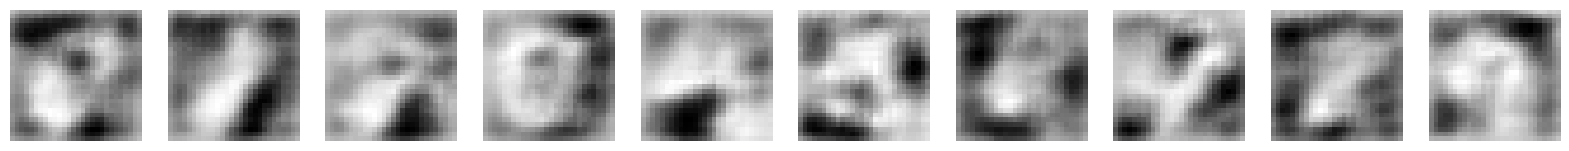

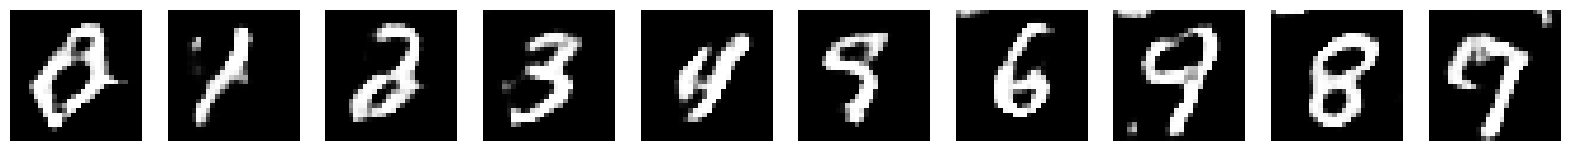

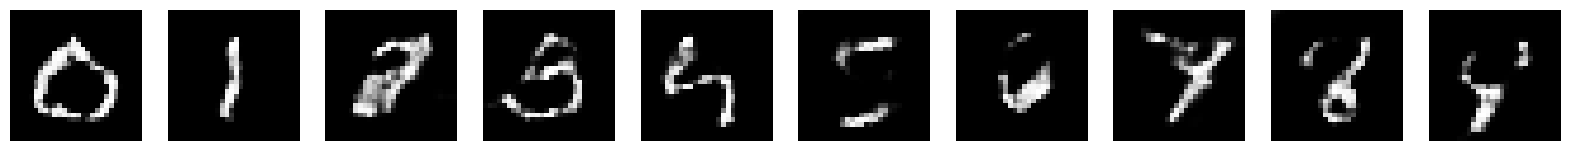

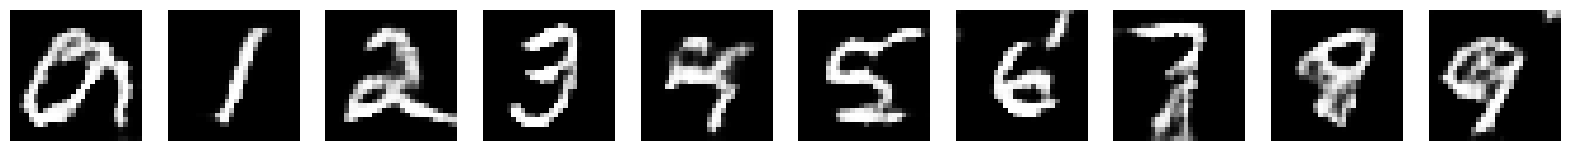

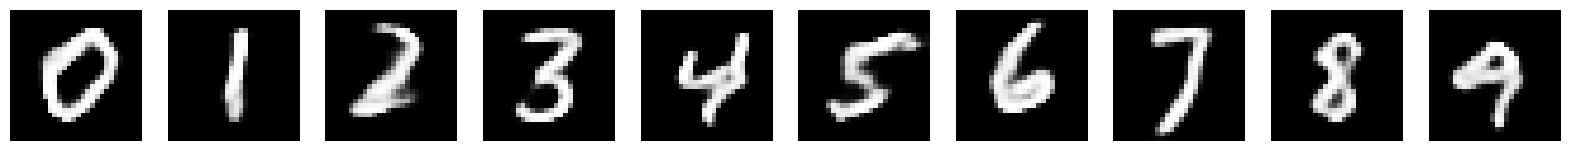

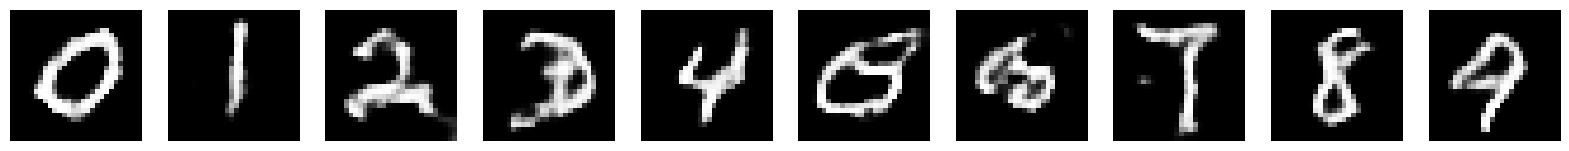

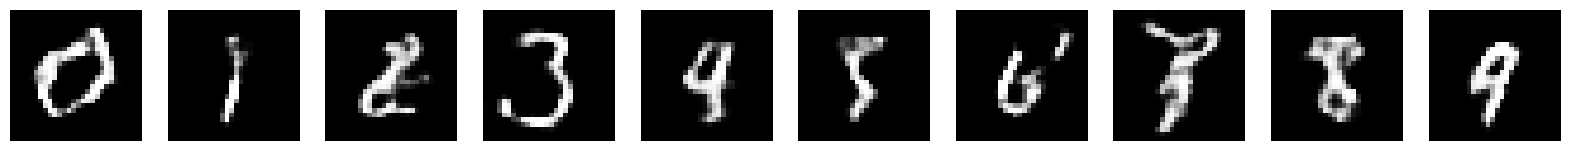

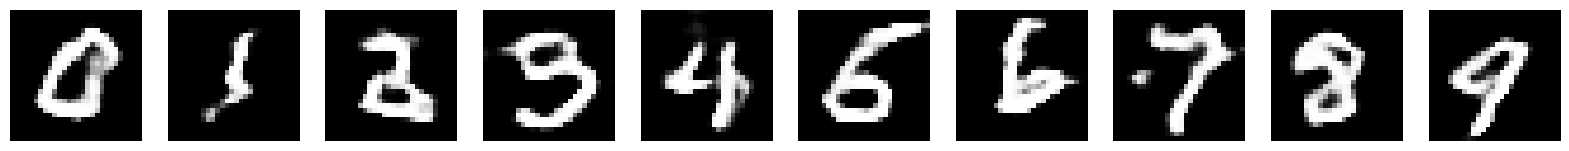

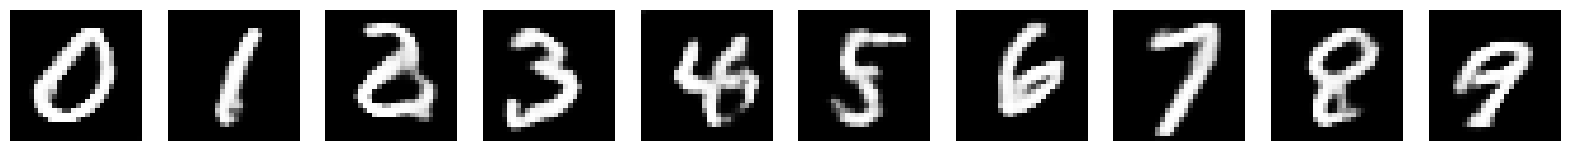

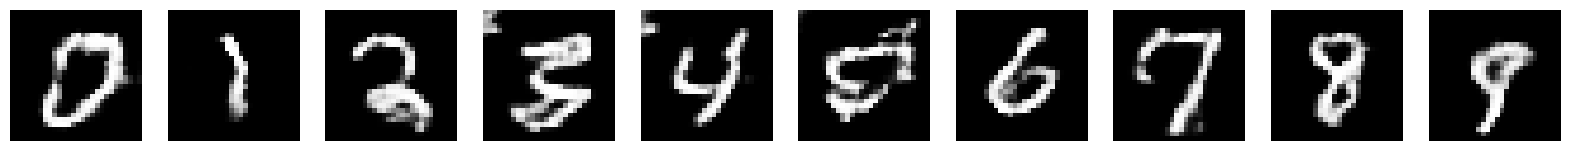

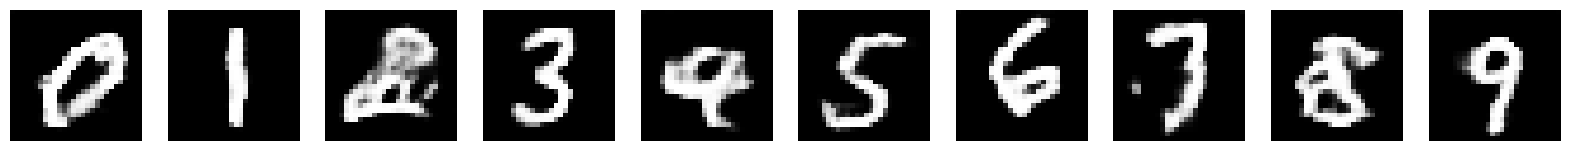

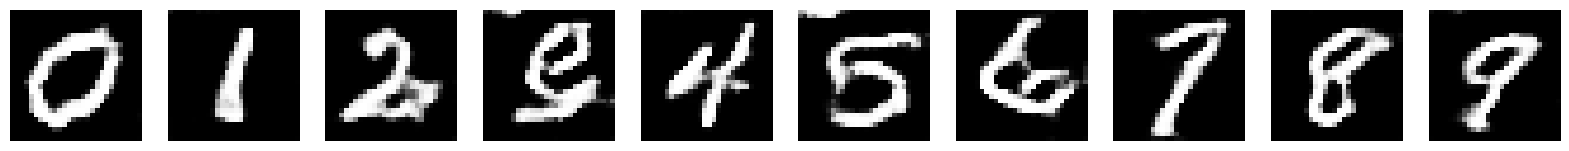

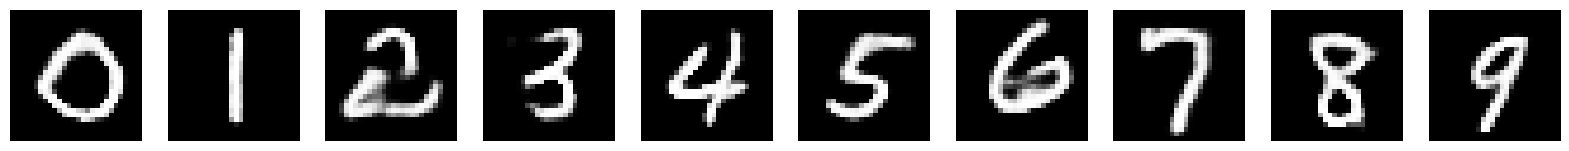

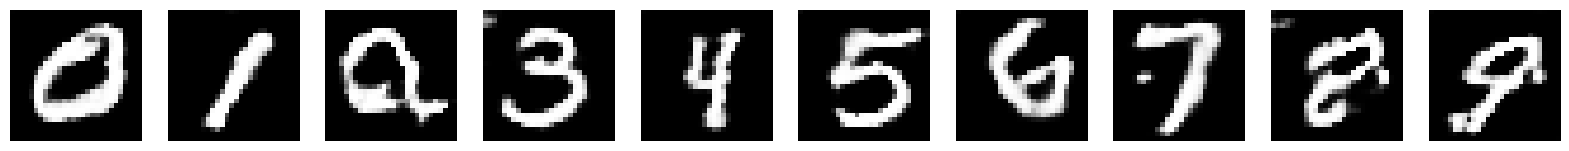

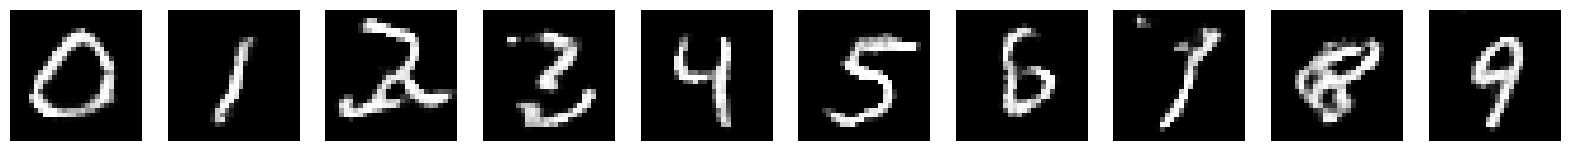

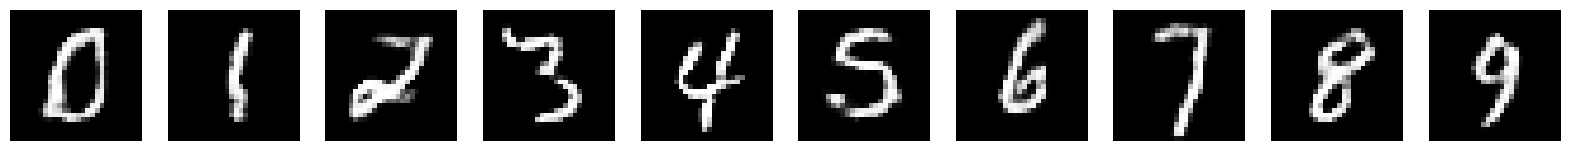

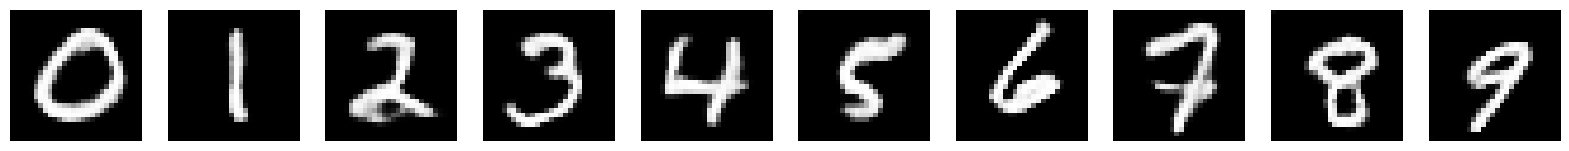

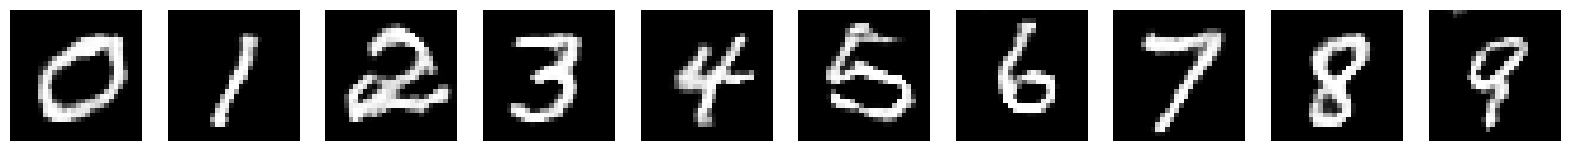

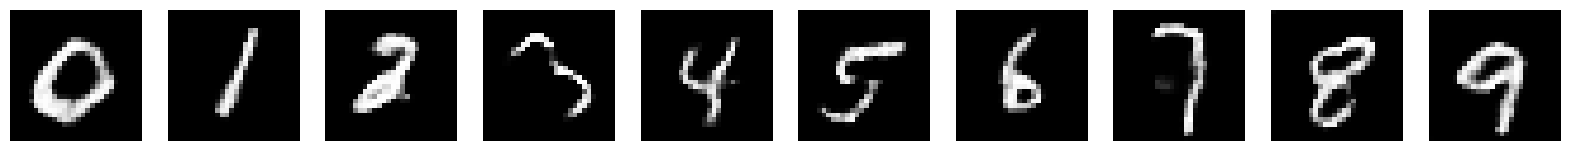

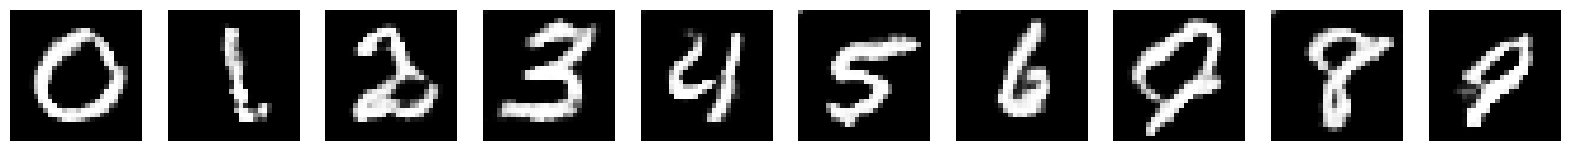

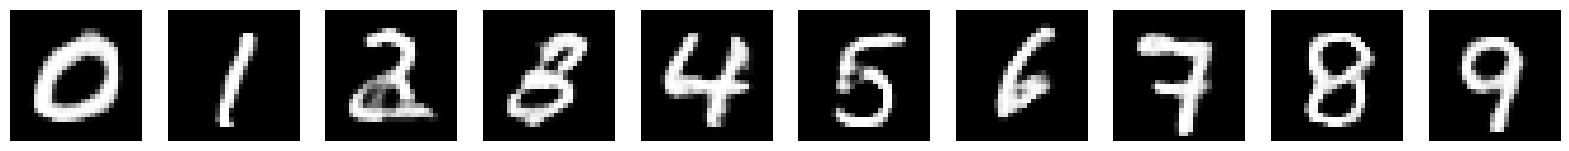

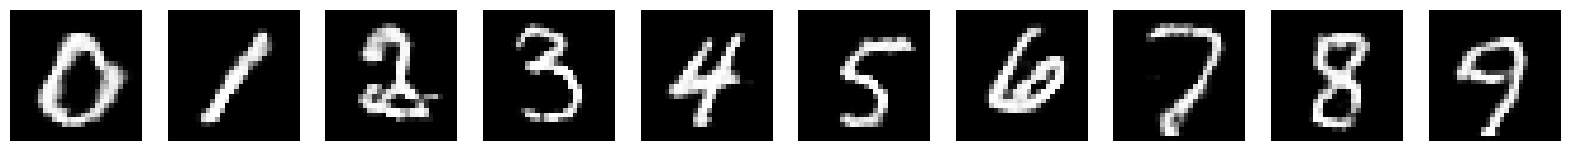

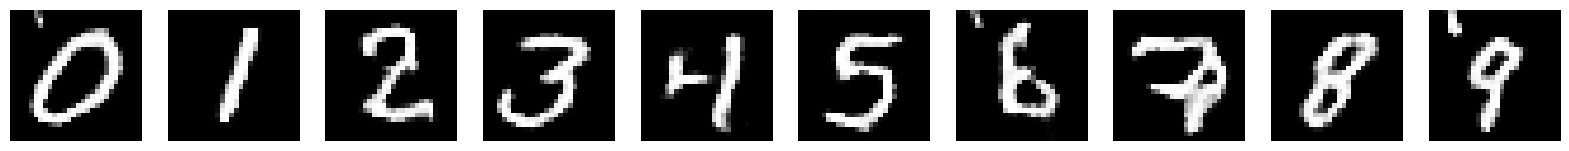

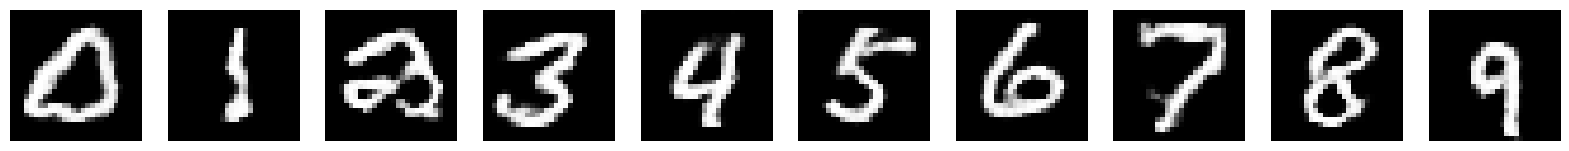

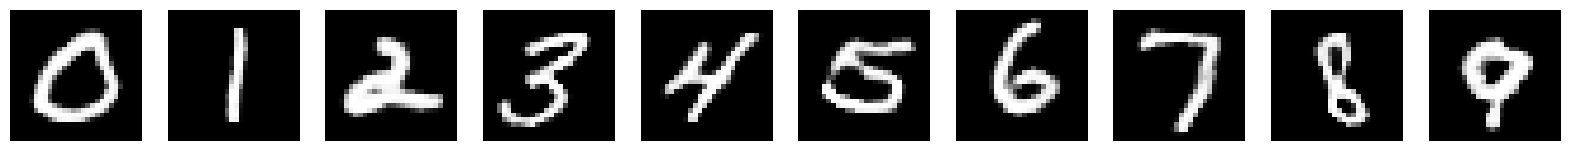

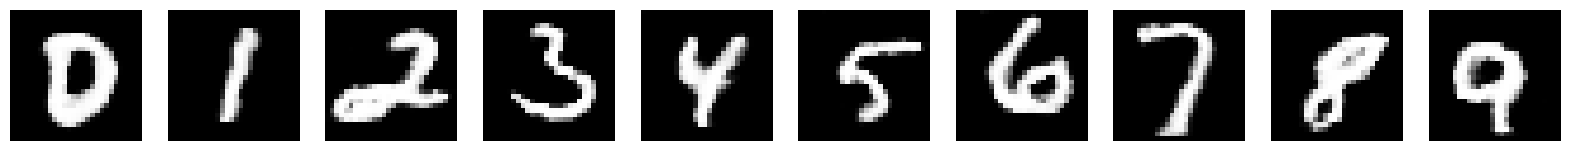

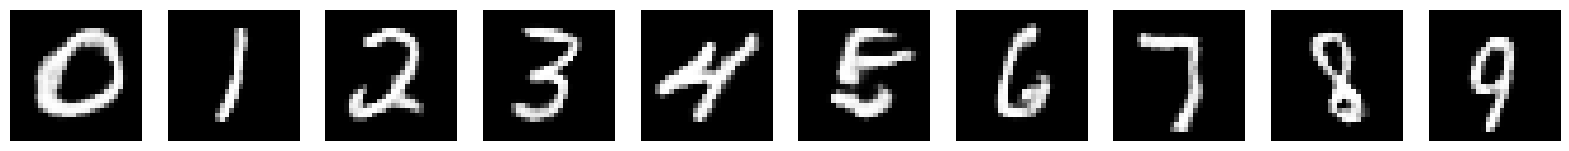

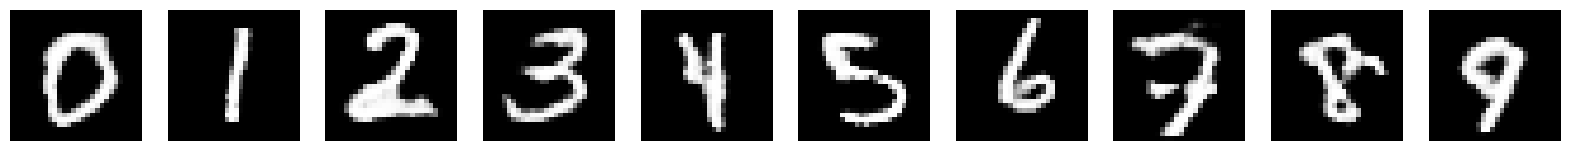

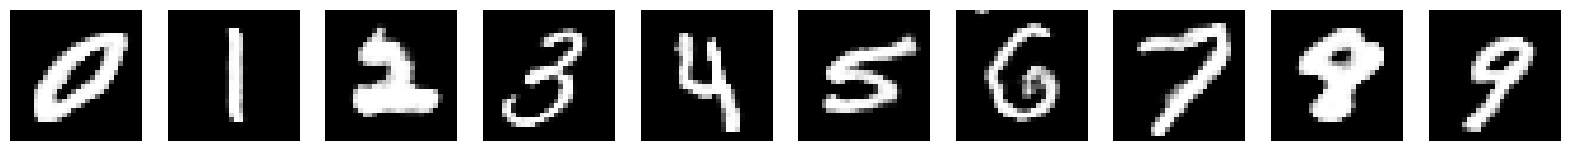

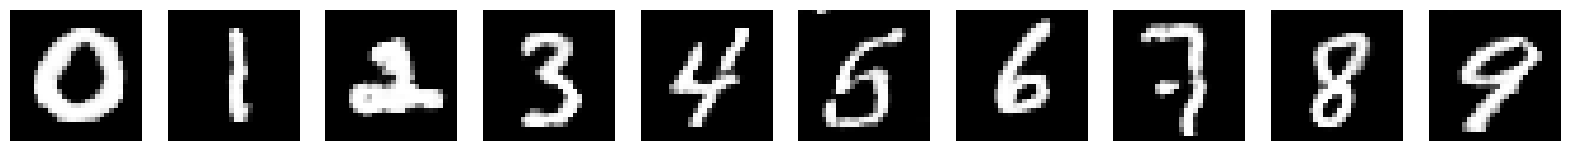

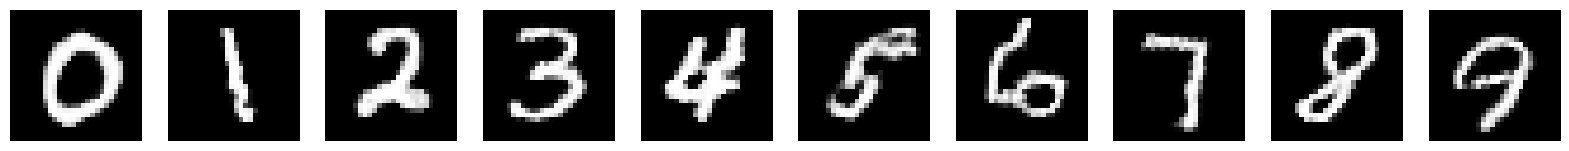

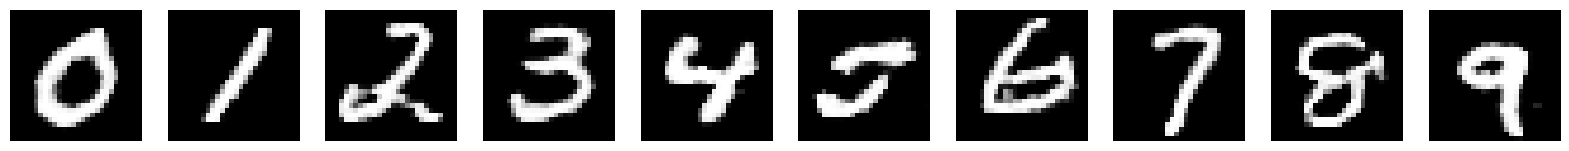

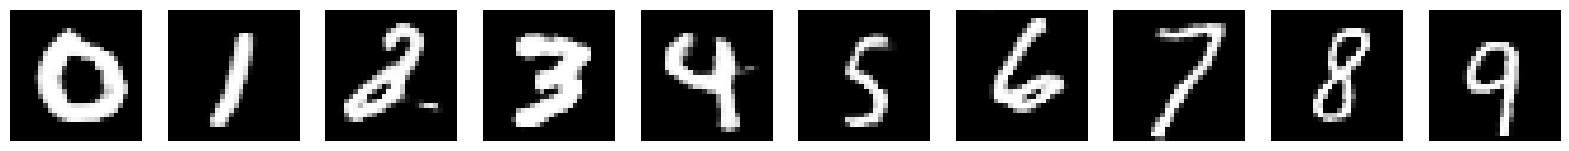

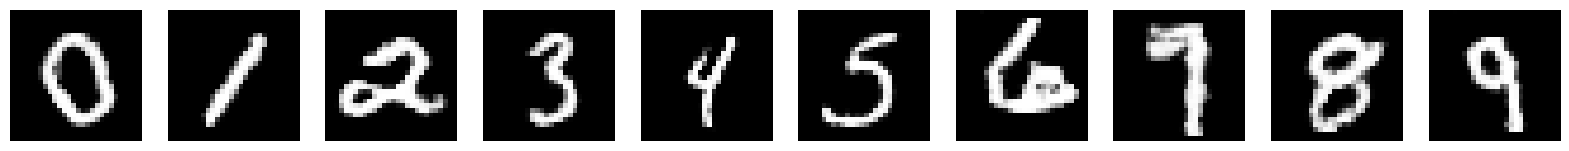

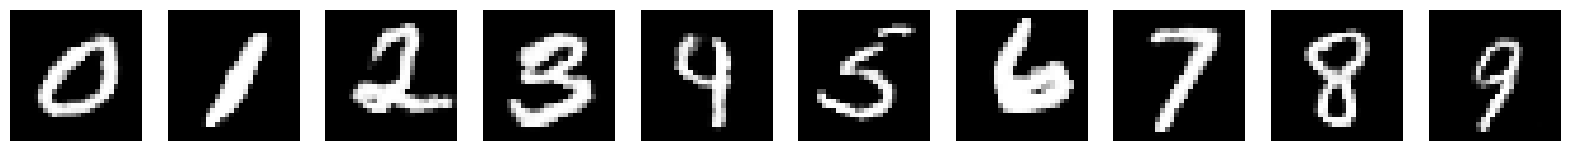

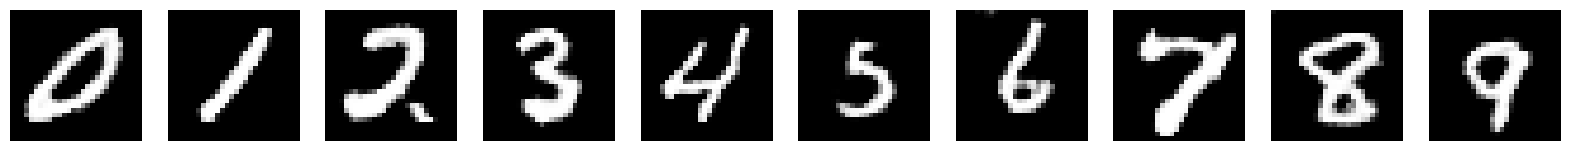

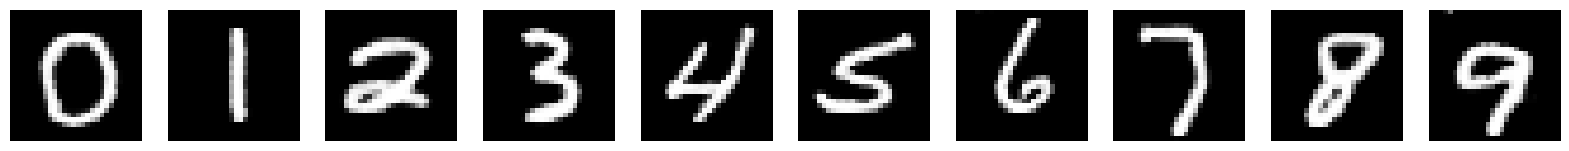

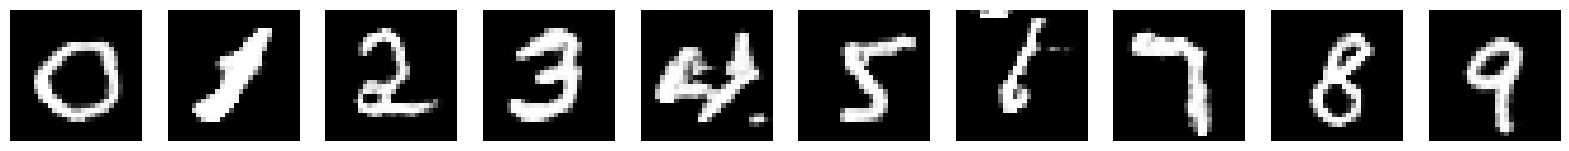

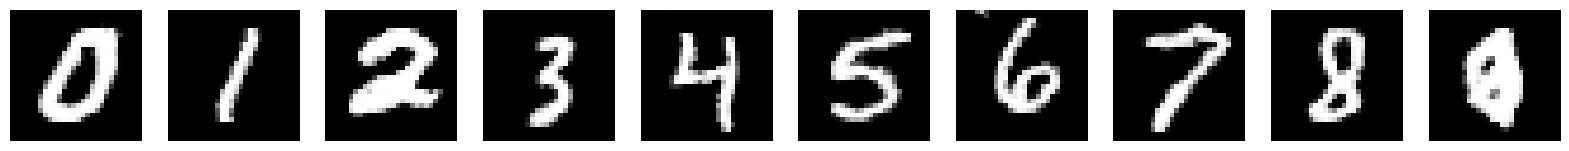

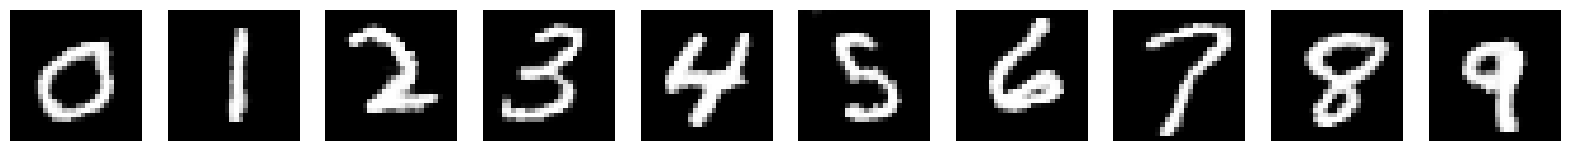

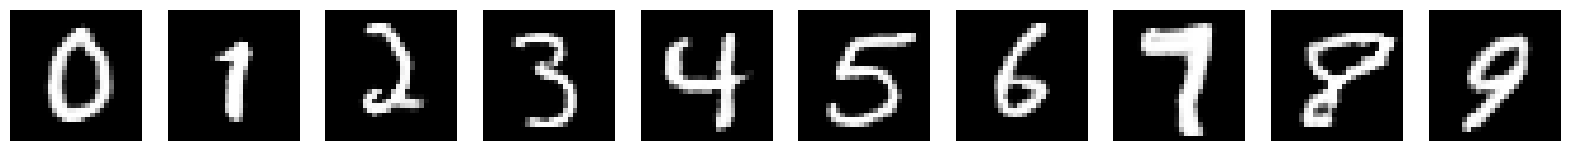

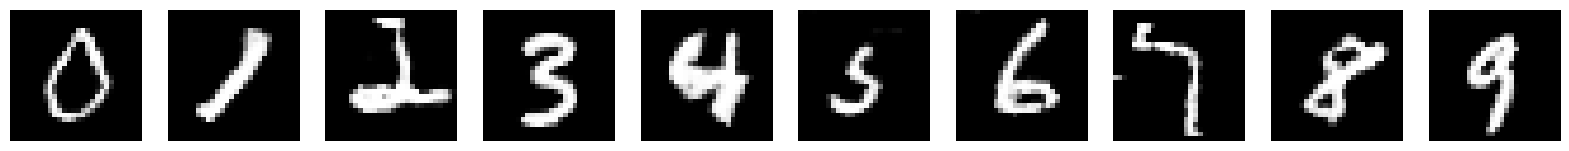

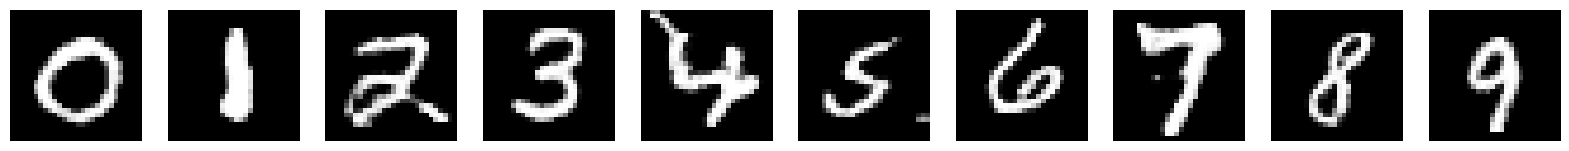

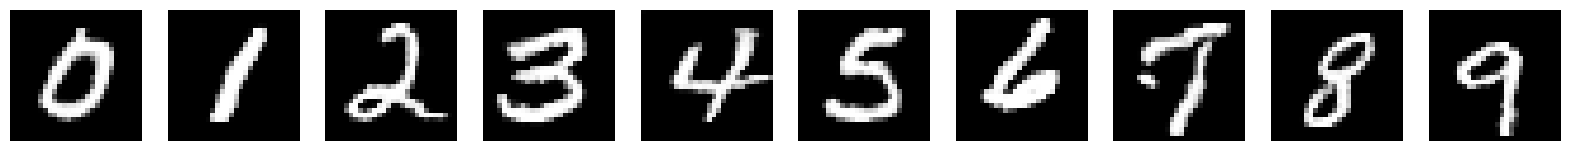

In [28]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 5, algo='FedPKDG')

Server.local_training(cnn_epochs = 0, gen_epochs=15, is_earlystop=False) #don't train cnn
print('>>>>>>>>>trained all clients gen round', _)
Server.agg_gen()
print('>>>>>>>>>Weighted aggregated client generator')
images=[]
for num in range(10):
  img=generate_image(Server.generator, num, 64)
  images.append(img[0])
print('Global')
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Hide axes

for c_idx, client in enumerate(client_list):
  images=[]
  for num in range(10):
    img=generate_image(client.generator, num, 64)
    images.append(img[0])
  print('Client', c_idx)

  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  for ax, img in zip(axes, images):
      ax.imshow(img, cmap='gray')
      ax.axis('off')  # Hide axes

total_rounds = 10
for round in range(total_rounds):
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  Server.local_training(cnn_epochs = 0) #don't train cnn
  print('>>>>>>>>>trained all clients gen round', round)
  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')
  images=[]
  for num in range(10):
    img=generate_image(Server.generator, num, 64)
    images.append(img[0])
  print('Global')
  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  for ax, img in zip(axes, images):
      ax.imshow(img, cmap='gray')
      ax.axis('off')  # Hide axes

  for c_idx, client in enumerate(client_list):
    images=[]
    for num in range(10):
      img=generate_image(client.generator, num, 64)
      images.append(img[0])
    print('Client', c_idx)

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Hide axes

### Kid Score

In [38]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import polynomial_kernel
from keras.models import load_model
from PIL import Image

# Function to scale images to the size required by InceptionV3 (299x299) and convert grayscale to RGB
def scale_images(images, new_shape):
    images_list = []
    for img in images:
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB by repeating channels
        new_image = array_to_img(img)
        new_image = new_image.resize(new_shape, Image.NEAREST)
        images_list.append(img_to_array(new_image))
    return np.array(images_list)

# Function to calculate the activations of the images using the InceptionV3 model
def calculate_activations(images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = preprocess_input(images)
    activations = model.predict(images)
    return activations

# Function to calculate the KID score
def calculate_kid(act1, act2):
    act1, act2 = np.atleast_2d(act1), np.atleast_2d(act2)
    m = act1.shape[0]
    n = act2.shape[0]

    k_11 = polynomial_kernel(act1, act1, degree=3)
    k_22 = polynomial_kernel(act2, act2, degree=3)
    k_12 = polynomial_kernel(act1, act2, degree=3)

    kid = k_11.sum() / (m * m) + k_22.sum() / (n * n) - 2 * k_12.sum() / (m * n)
    return kid

# Load the MNIST dataset
(_, _), (real_images, _) = mnist.load_data()
real_images = np.expand_dims(real_images, axis=-1)

# Assuming your GAN generator is defined and loaded
# generator = ... (Your trained GAN generator model)
# Example: generator = load_model('path_to_your_trained_generator.h5')

# Generate images using the GAN generator
num_images = 100  # Number of images to generate
latent_dim = 64  # Example latent dimension, replace with your generator's input dimension

generated_images=pseudoDataset(Server.generator, num_images, latent_dim, is_augment=False, batch_size=64)

# Scale both sets of images
generated_images = scale_images(generated_images[0], (299, 299))
real_images = scale_images(real_images[:num_images], (299, 299))  # Use the same number of real images as generated

# Calculate the activations
act1 = calculate_activations(generated_images)
act2 = calculate_activations(real_images)

# Calculate the KID score
kid = calculate_kid(act1, act2)
print(f'KID score: {kid}')


Added (100,) data points to the public dataset
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
KID score: 0.011948144531249927


In [40]:
for client in client_list:
  print(kid_score(client.generator))

Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
KID score: 0.009387304687499931
None
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
KID score: 0.008546386718749854
None
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
KID score: 0.011083691406249763
None


discovery:

It has shown that the first aggregated generator cannot produce sensible output. After training on the aggregated global generator on clients' local data, the global generator starts to produce better images than client ones. For the first few rounds, the client generator show distinct features about the private dataset shown as the boldness of the handwriting, such distinction gradually fade and generators converge towards later communication rounds.


how it impacts design:
- initialise with training the local generators to convergence (20 epochs), for some reason the earlystopping always stop too early.
- for every communication round train the local generator for less epochs to prevent overfitting -- use earlystopping ~3 epochs
- only start generating public dataset after 1st round of fine-tuning global models on client data.




## Communication Frequency

trial 1. aggregate only after convergence

- 20 on gen
5x
- cnn: 2 fine 3 prune
- gen: 5 with early stop
- 1000 fake, 320 fake later
- distill: 3 epochs of < 50 steps/epoch (too little) -> bad global model performance -> all cnn model accuracies collapses from round 2 and stays to as low as ~0.1

trial 2.
- 15 on gen
- cnn 2 fine 4 prune
- gen 2 with early stop
- 1/2 * min datasize + 100 batch later, todo but not impl: delete oldest to cap at max datasize
- distill 5 epochs

training client 0 's CNN
training client 0 's GEN
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.4373 - g_loss: 1.5105
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - d_loss: 0.4602 - g_loss: 1.2514
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.5255 - g_loss: 1.3054
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.5428 - g_loss: 1.2240
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.4900 - g_loss: 1.3441
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.4977 - g_loss: 1.2882
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - d_loss: 0.4499 - g_loss: 1.3619
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.4008 - g_loss: 1.6509
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.1646 - g_loss: 3.4568
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.2964 - g_loss: 1.9291
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.2258 - 

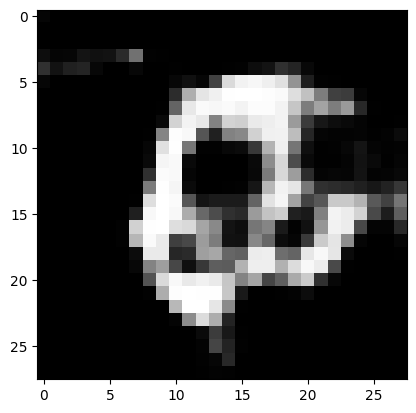

Client 0


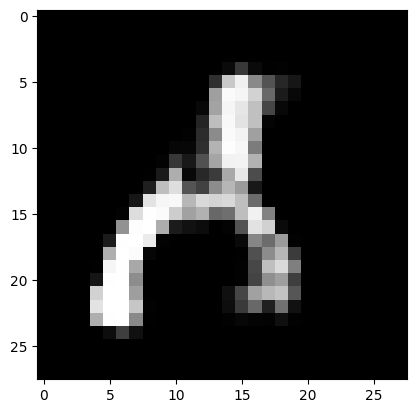

Client 1


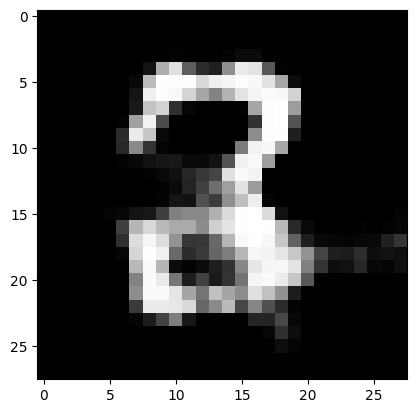

Client 2


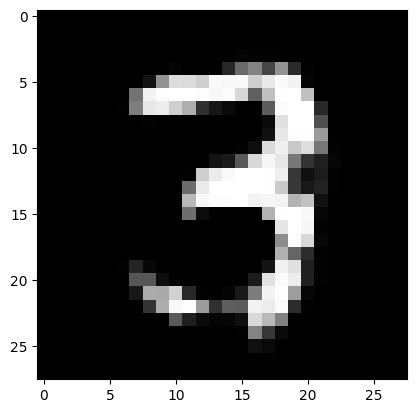

Client 3


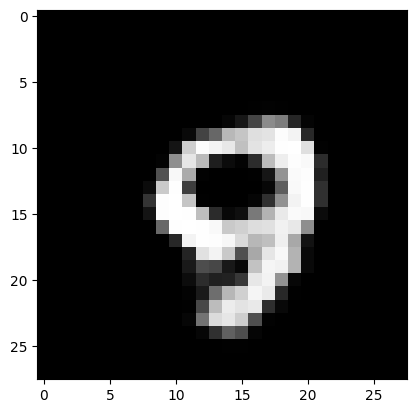

Client 4


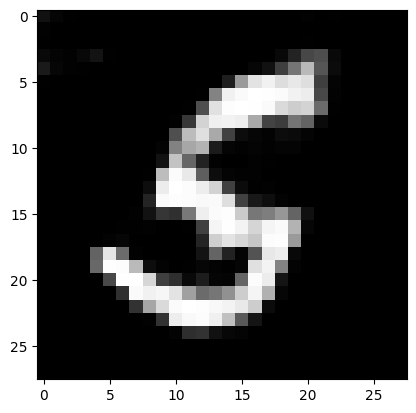

Client 5


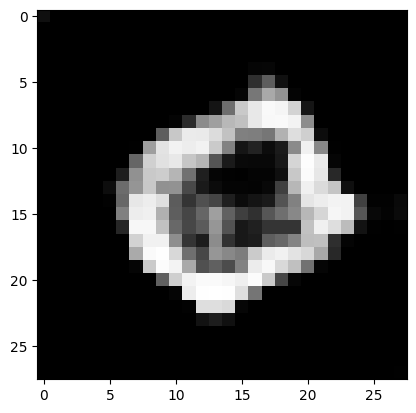

Client 6


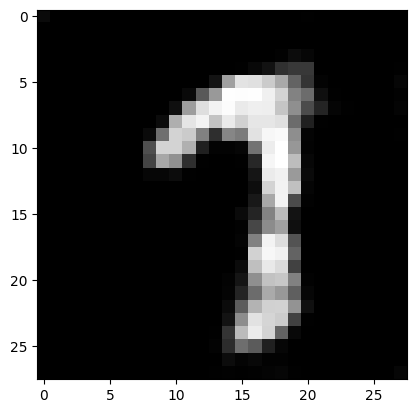

Client 7


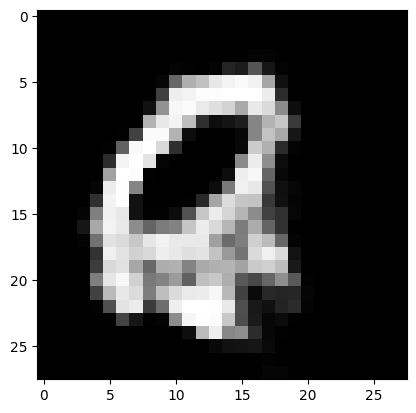

Client 8


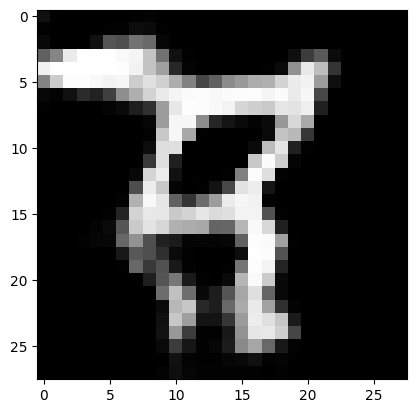

Client 9


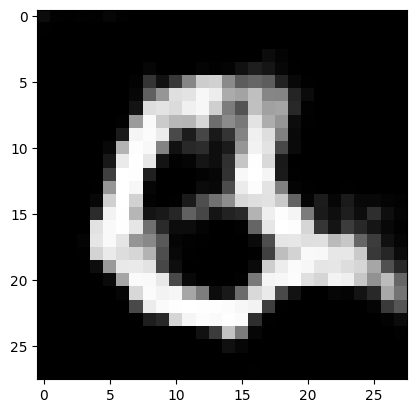

Client 0


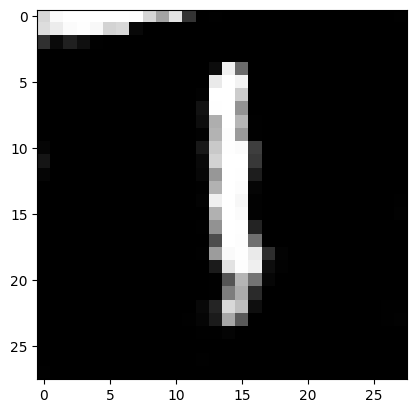

Client 1


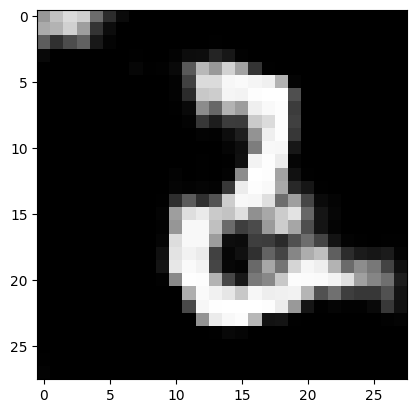

Client 2


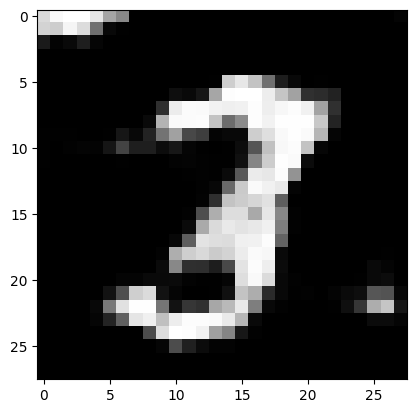

Client 3


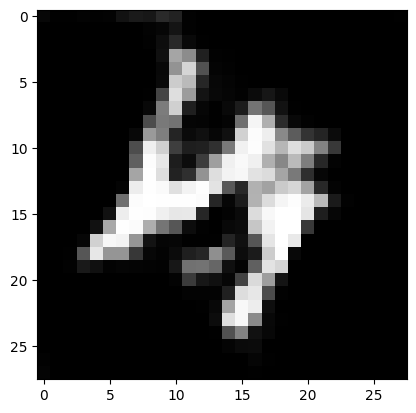

Client 4


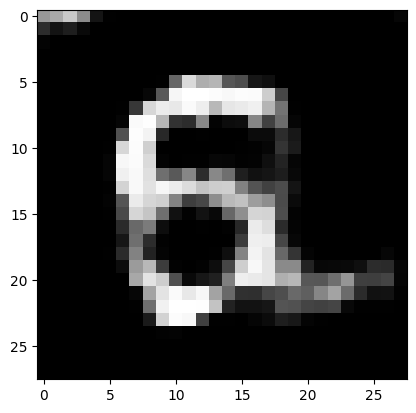

Client 5


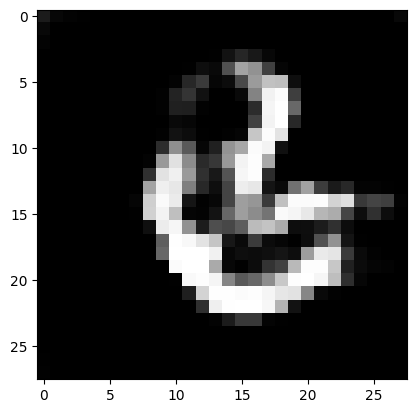

Client 6


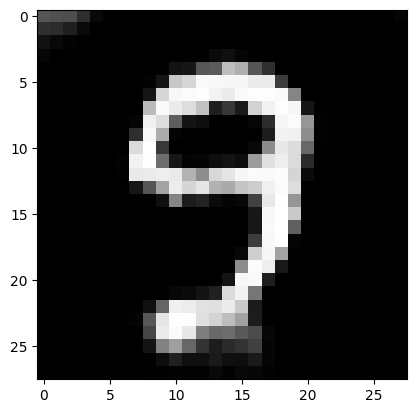

Client 7


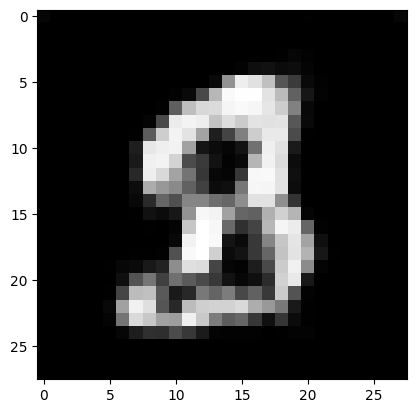

Client 8


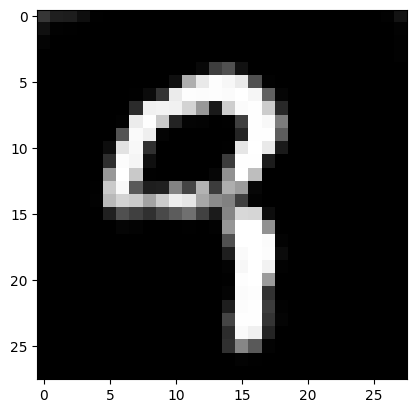

Client 9


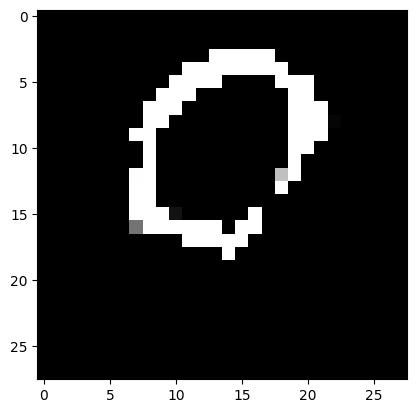

Client 0


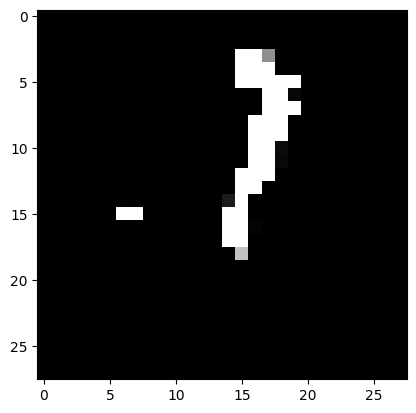

Client 1


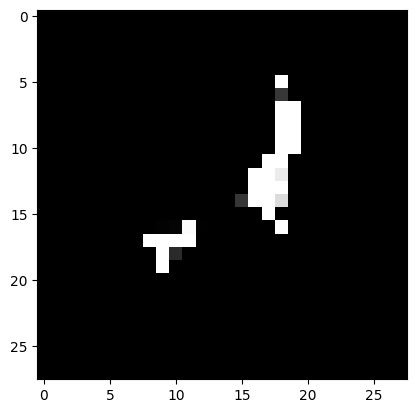

Client 2


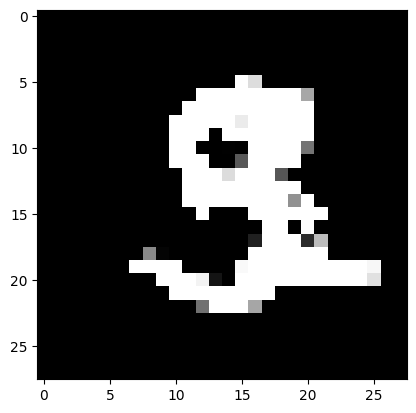

Client 3


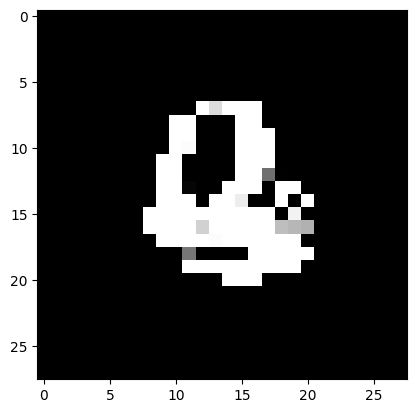

Client 4


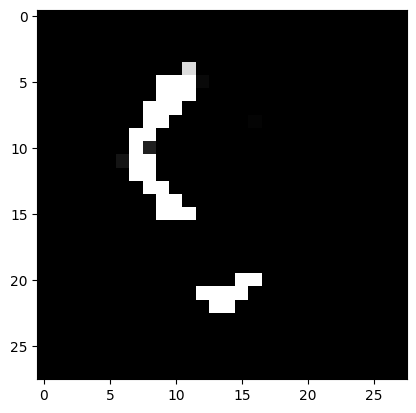

Client 5


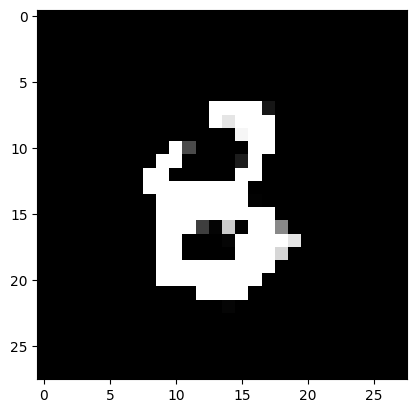

Client 6


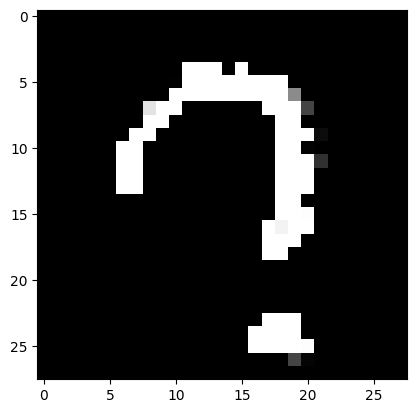

Client 7


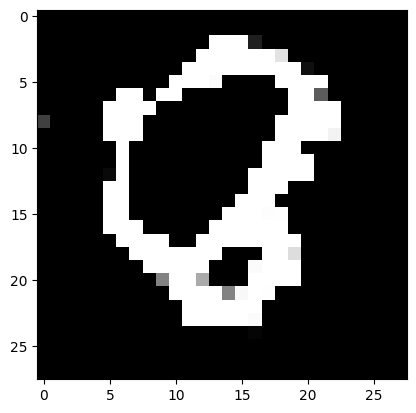

Client 8


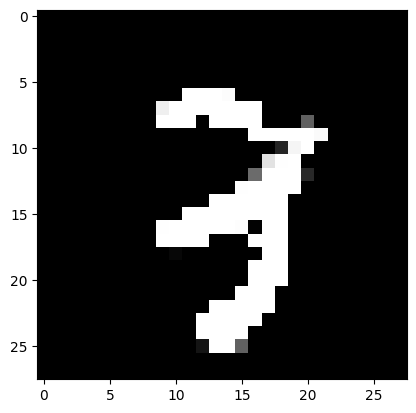

Client 9
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
********* ROUND 0 *********
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 562 end_step= 1687 target_sparsity= 0.0
Epoch 1/6
282/282 [==============================] - 6s 8ms/step - loss: 0.8210 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.3424 - val_sparse_categorical_accuracy: 0.9000
Epoch 2/6
282/282 [==============================] - 2s 5ms/step - loss: 0.3534 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.2770 - val_sparse_categorical_accuracy: 0.9180
Epoch 3/6
282/282 [==============================] - 2s 6ms/step - loss: 0.2919 - sparse_categorical_accuracy: 0.9126 - val_loss: 0.2309 - val_sparse_categorical_accuracy: 0.9315
Epoch 4/6
282/282 [==============================] - 2s 6ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9291 - val_loss: 0.1896 - val_spar

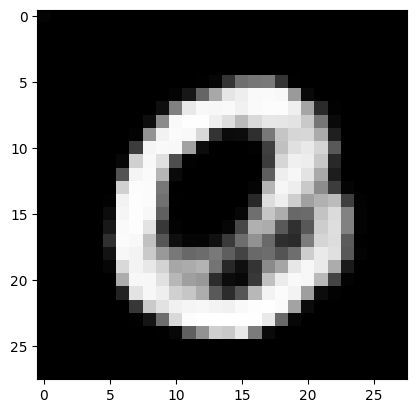

Global 0


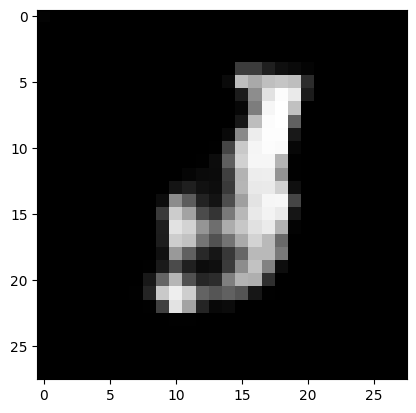

Global 1


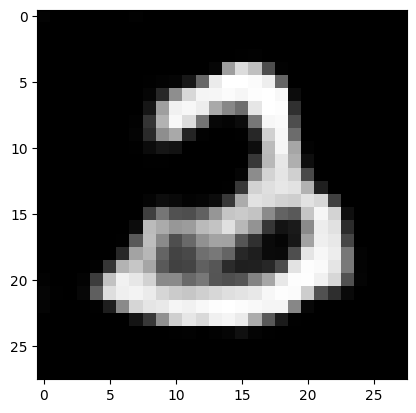

Global 2


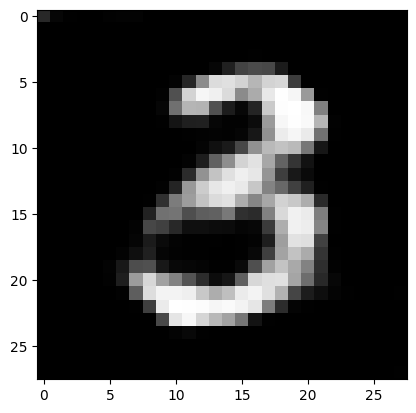

Global 3


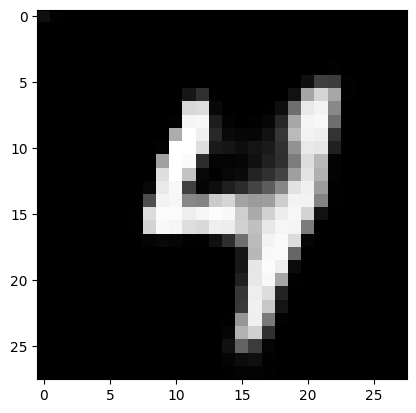

Global 4


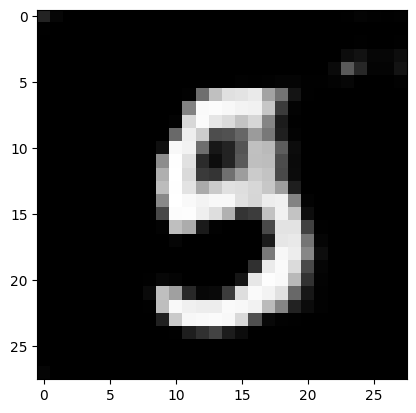

Global 5


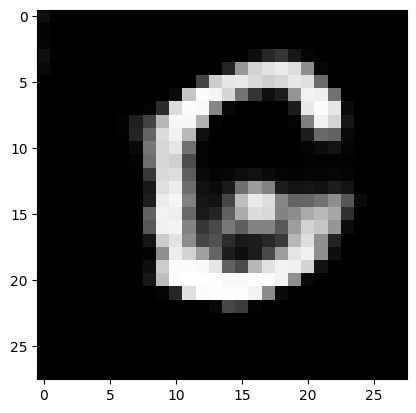

Global 6


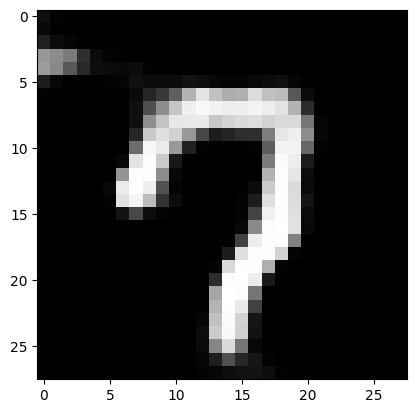

Global 7


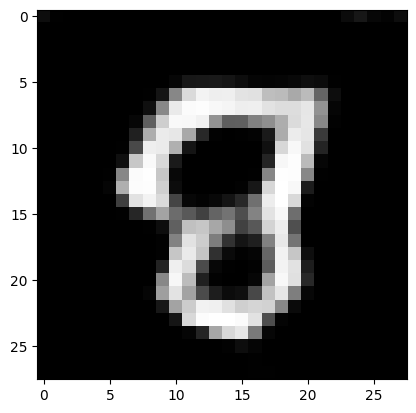

Global 8


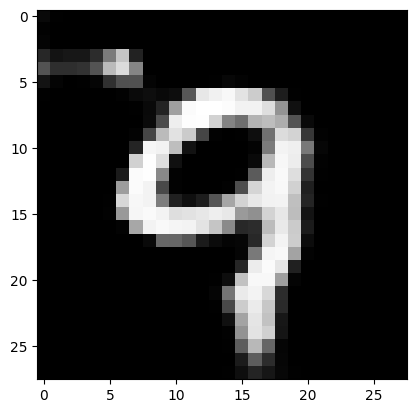

Global 9


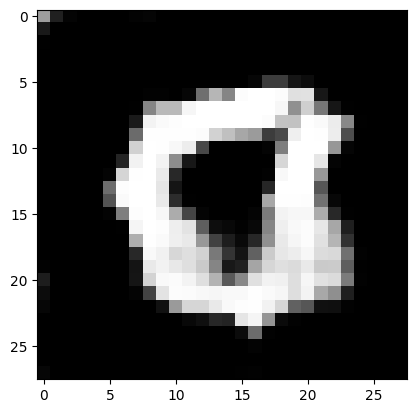

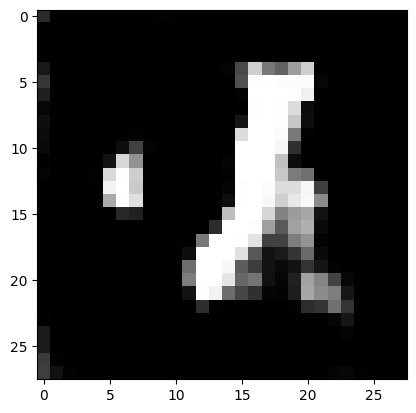

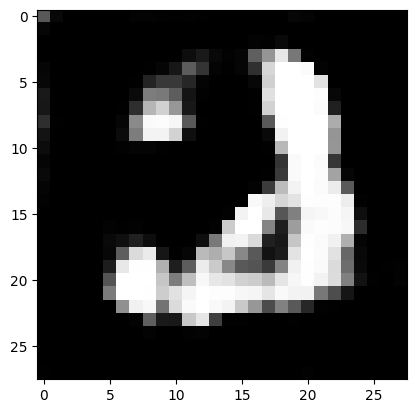

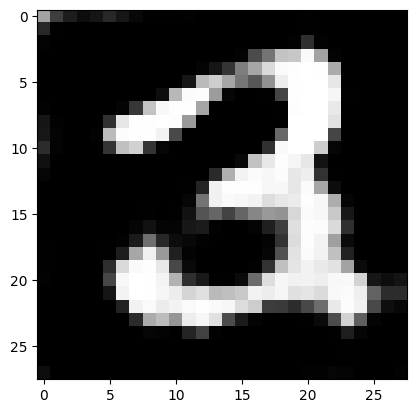

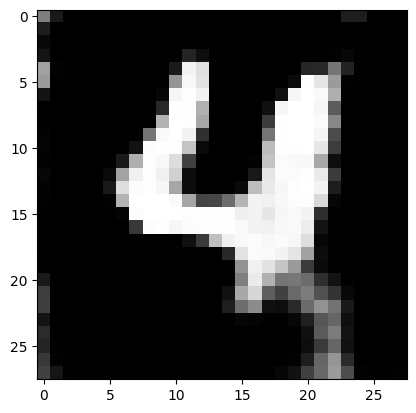

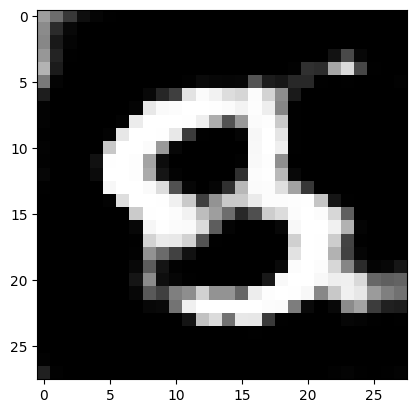

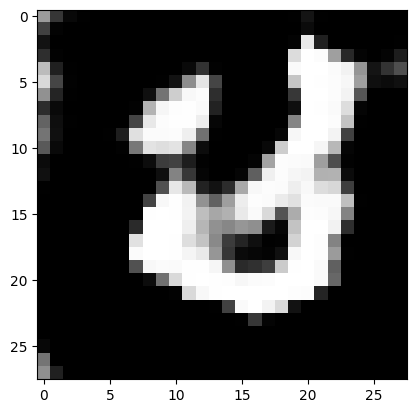

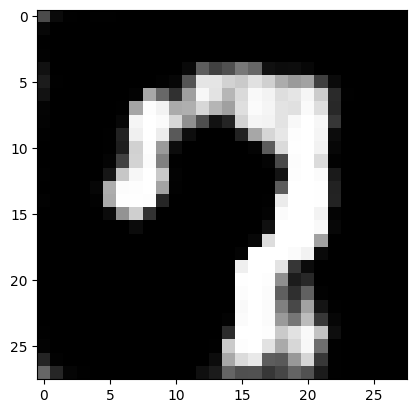

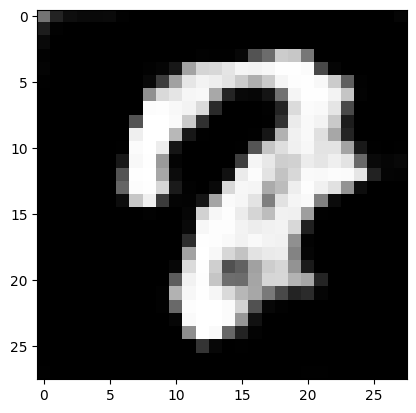

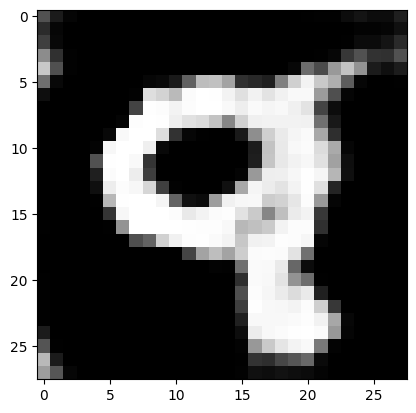

Client 9


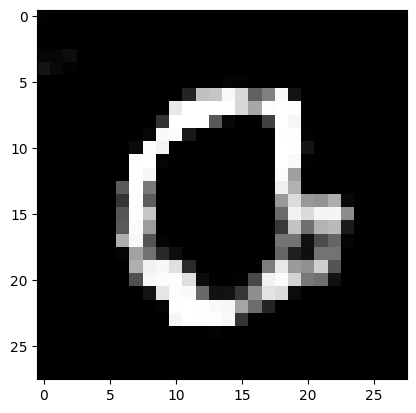

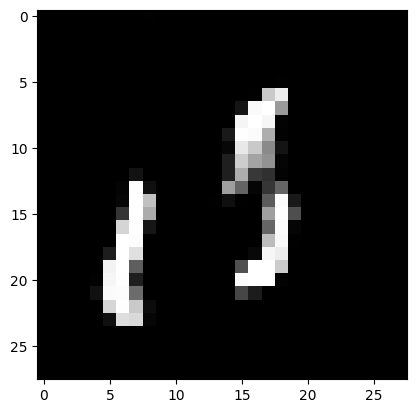

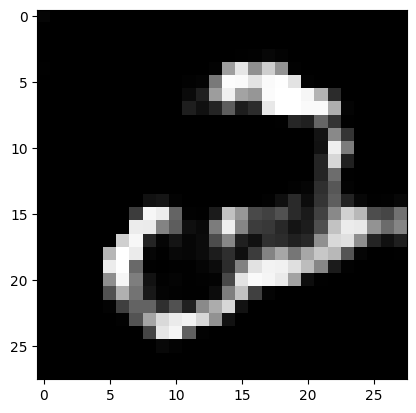

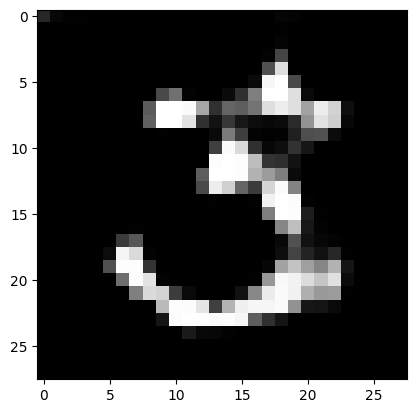

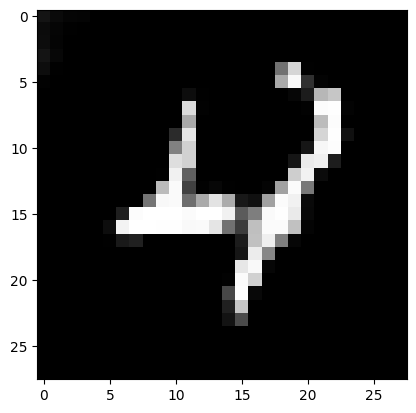

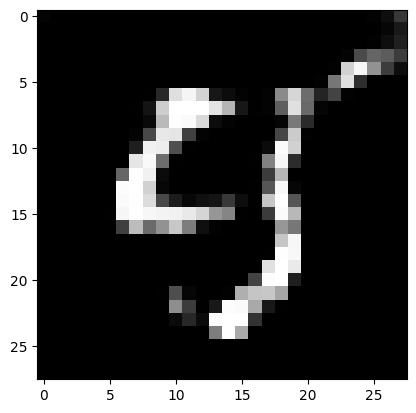

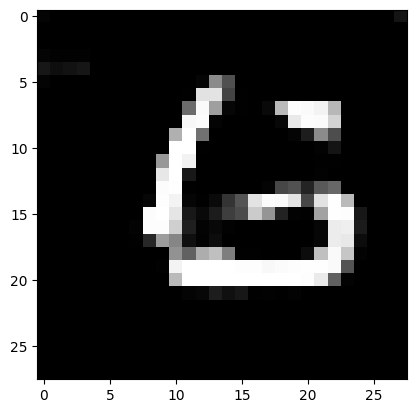

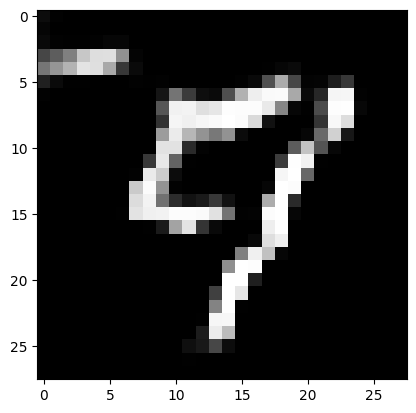

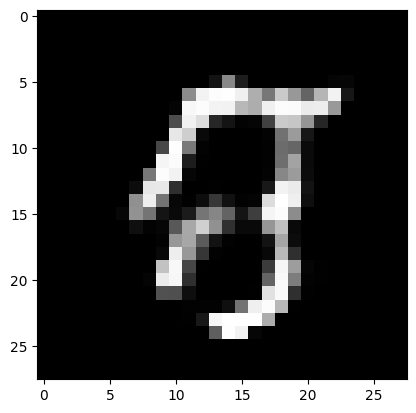

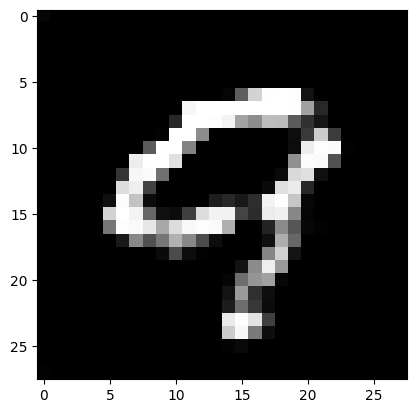

Client 9


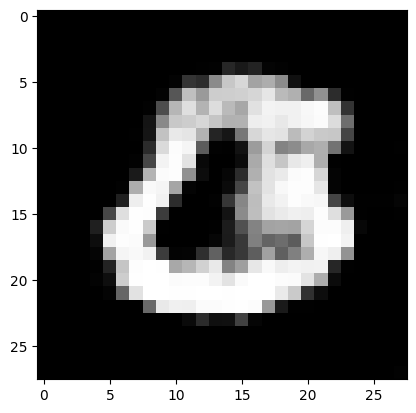

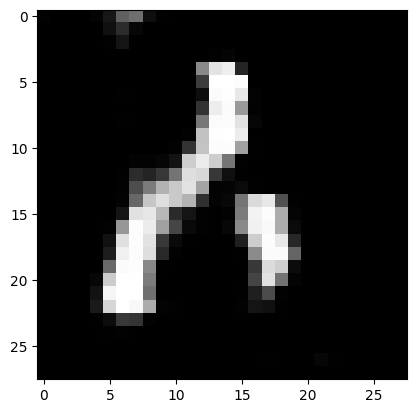

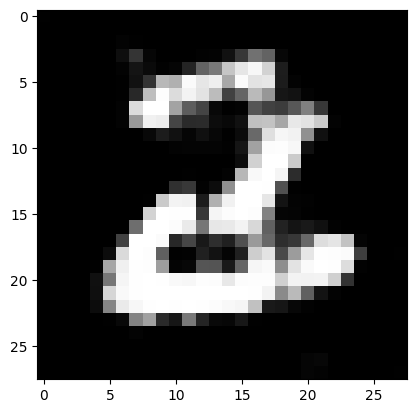

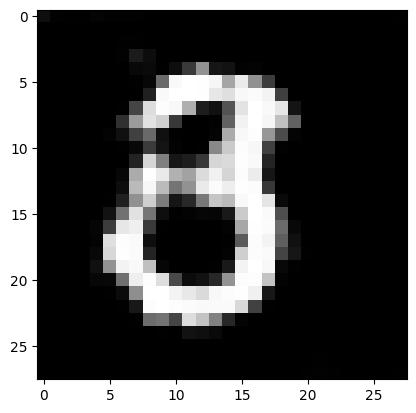

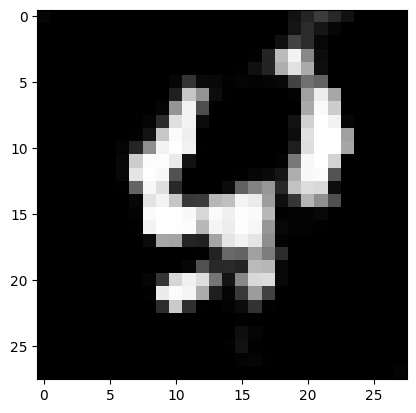

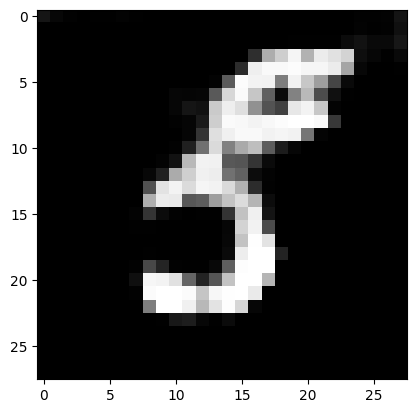

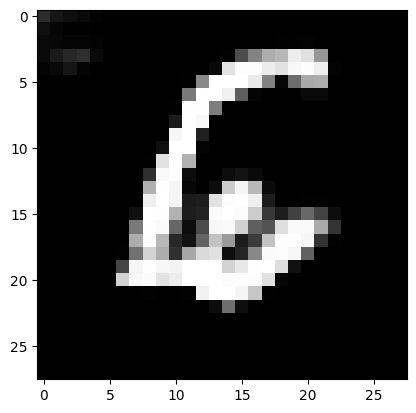

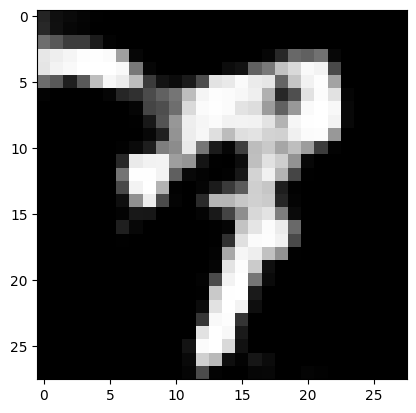

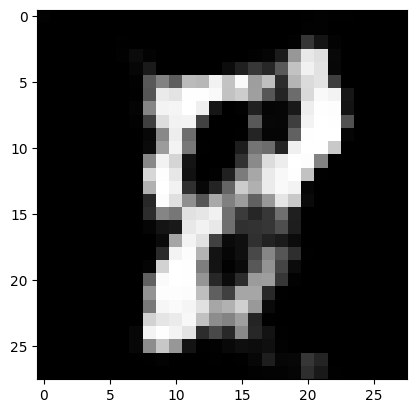

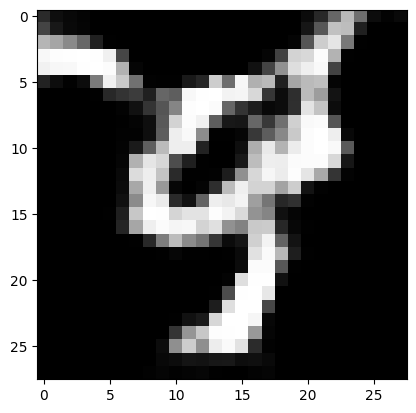

Client 9
Generating 1000 fake images of digit 0 ......
Generating 1000 fake images of digit 1 ......
Generating 1000 fake images of digit 2 ......
Generating 1000 fake images of digit 3 ......
Generating 1000 fake images of digit 4 ......
Generating 1000 fake images of digit 5 ......
Generating 1000 fake images of digit 6 ......
Generating 1000 fake images of digit 7 ......
Generating 1000 fake images of digit 8 ......
Generating 1000 fake images of digit 9 ......
Added (10000,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/5
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
282/282 [==============================] - 5s 8ms/step - sparse_

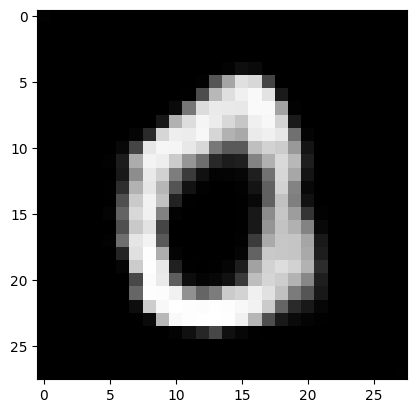

Global 0


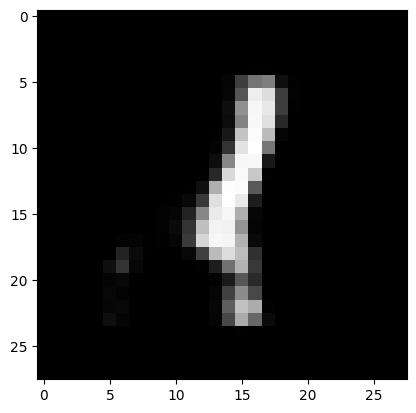

Global 1


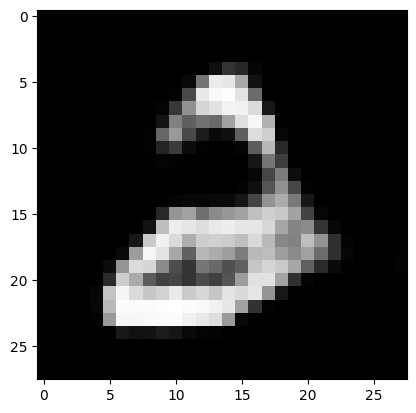

Global 2


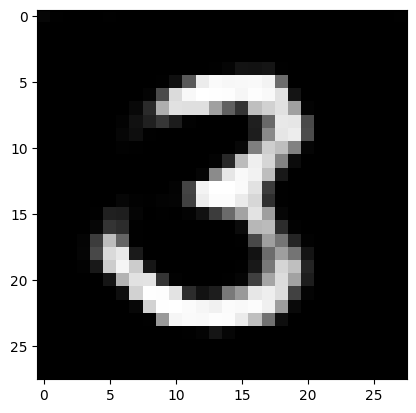

Global 3


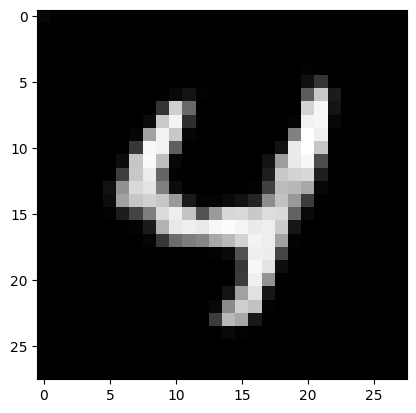

Global 4


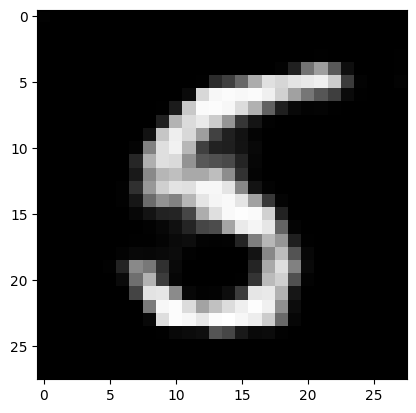

Global 5


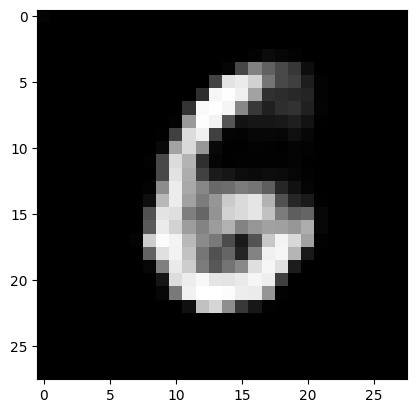

Global 6


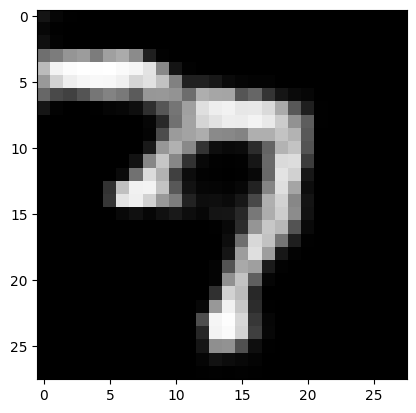

Global 7


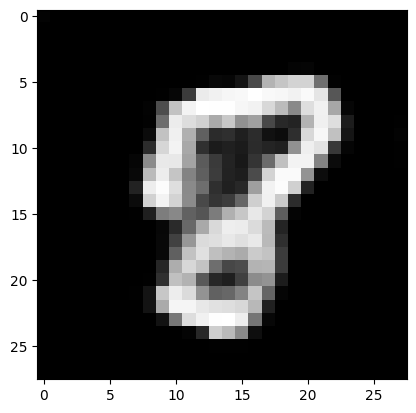

Global 8


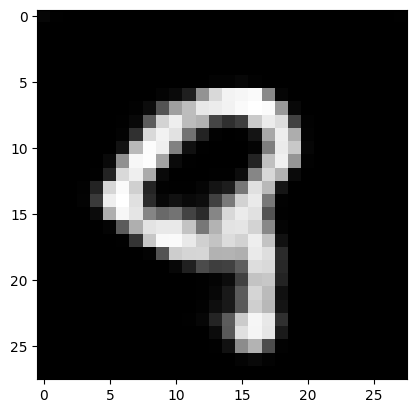

Global 9


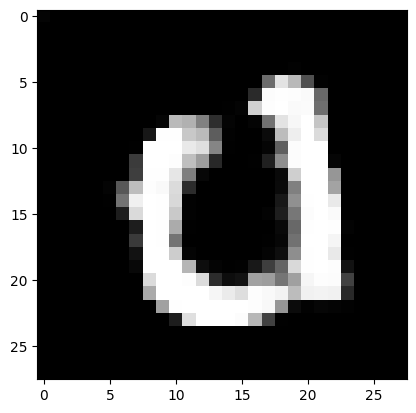

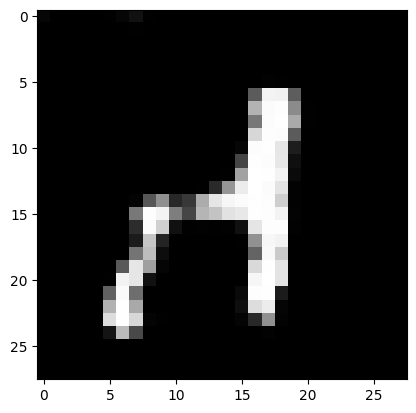

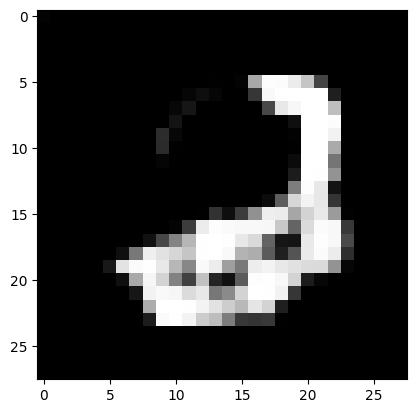

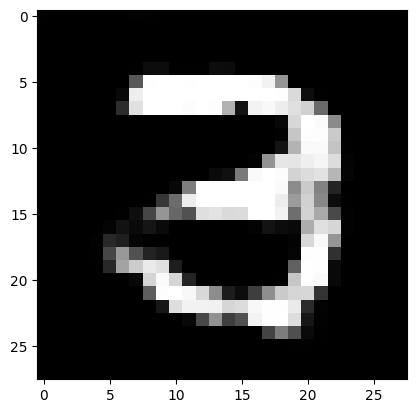

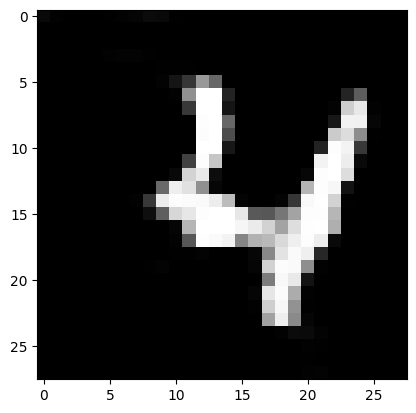

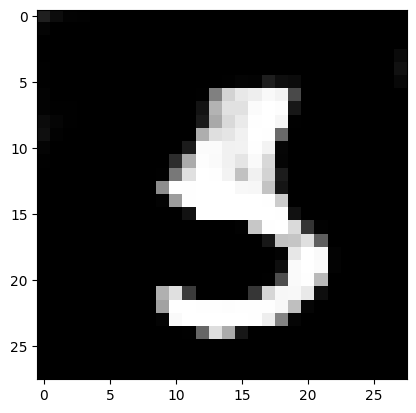

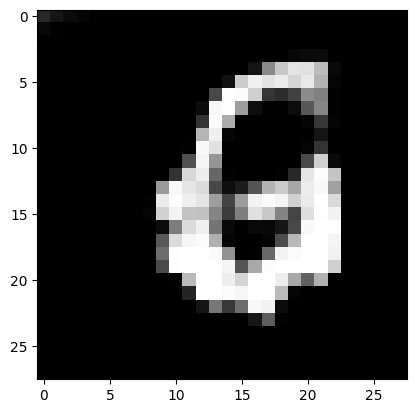

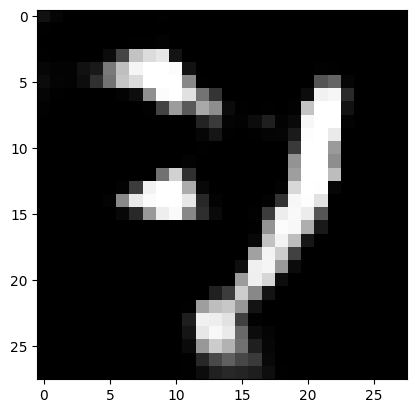

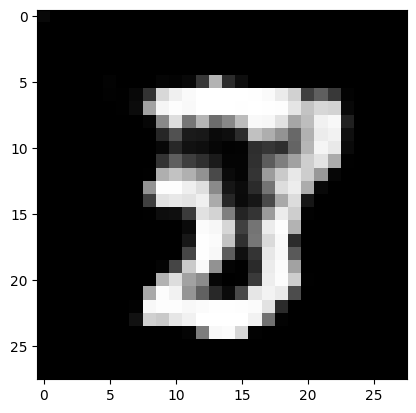

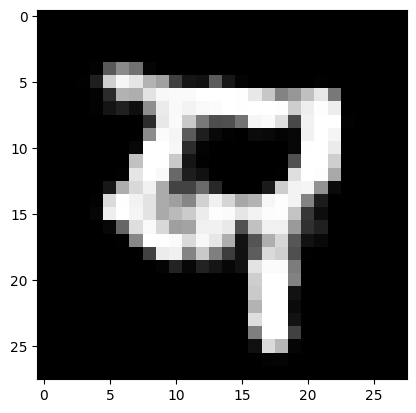

Client 9


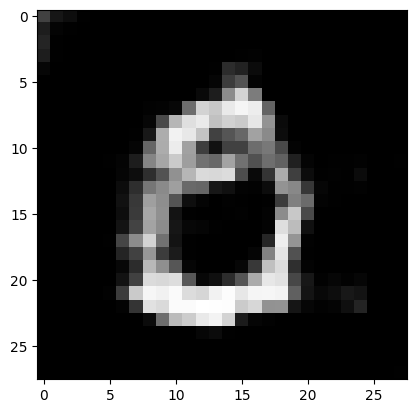

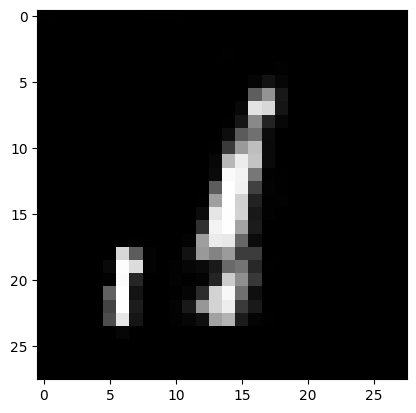

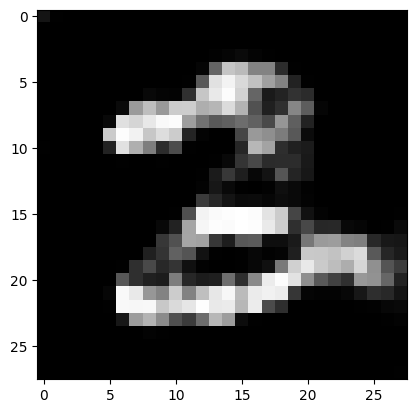

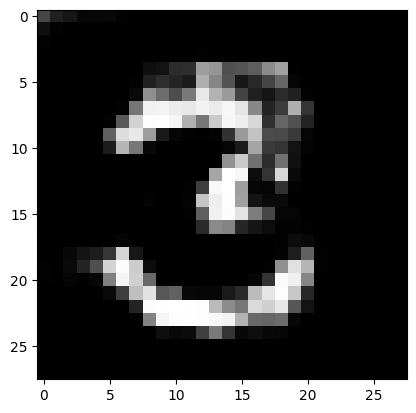

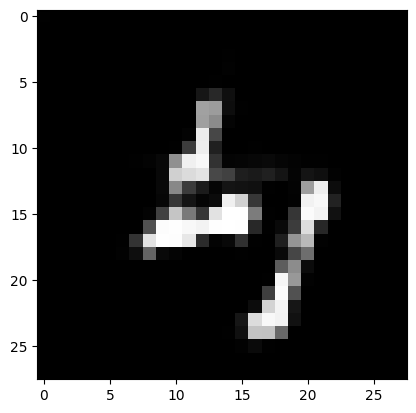

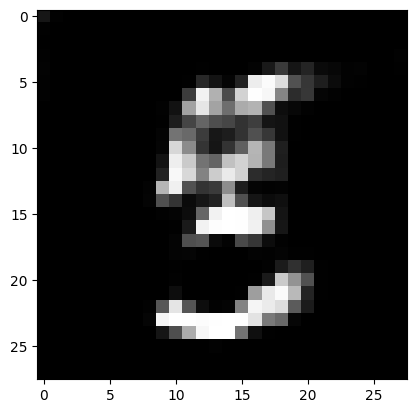

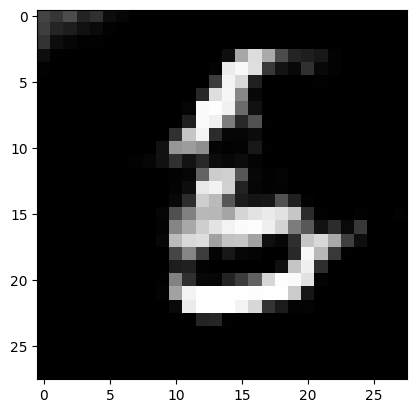

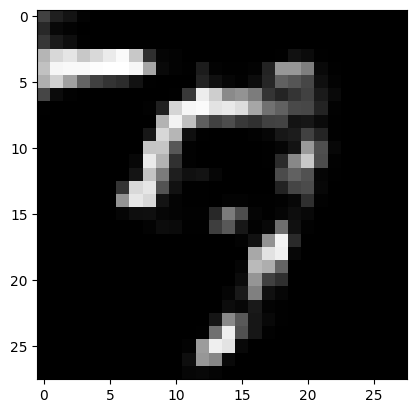

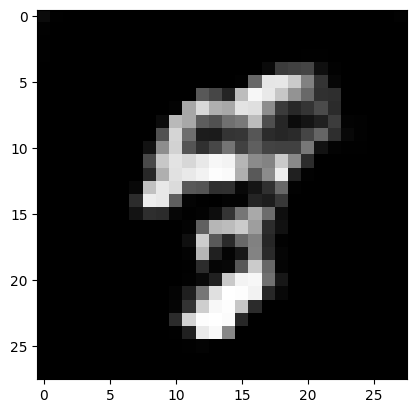

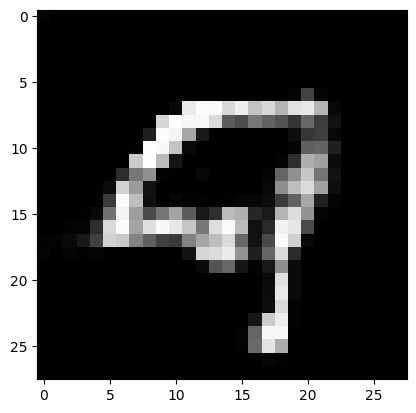

Client 9


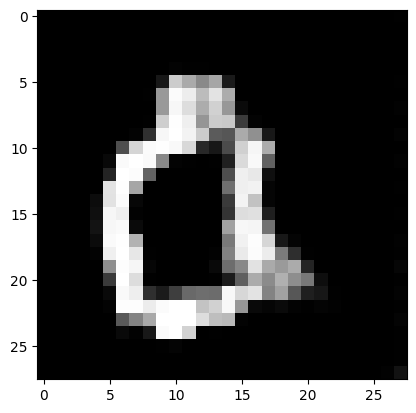

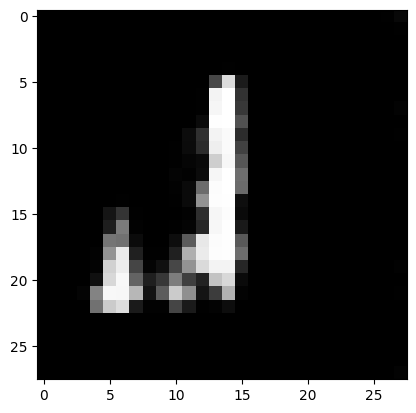

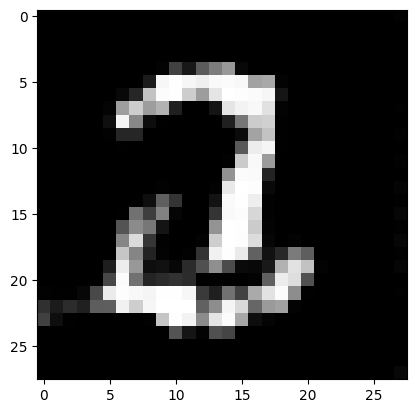

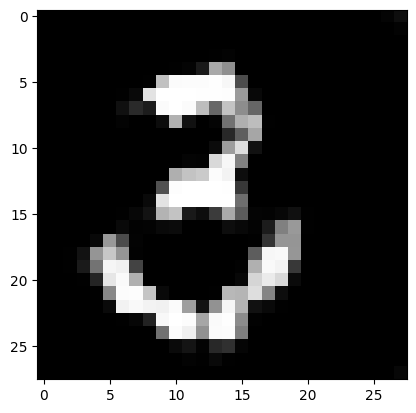

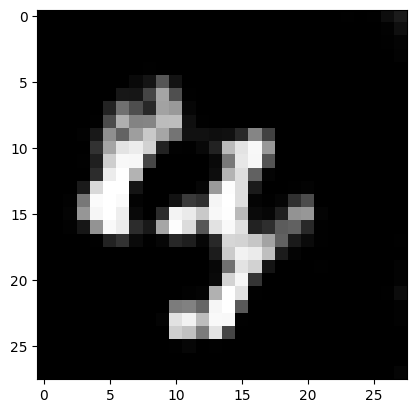

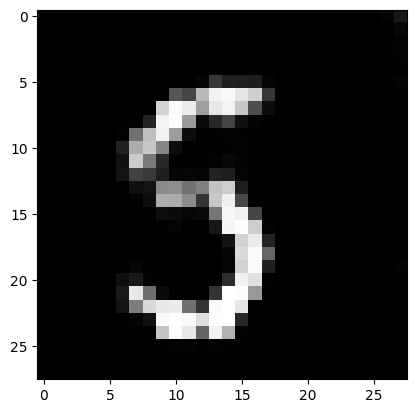

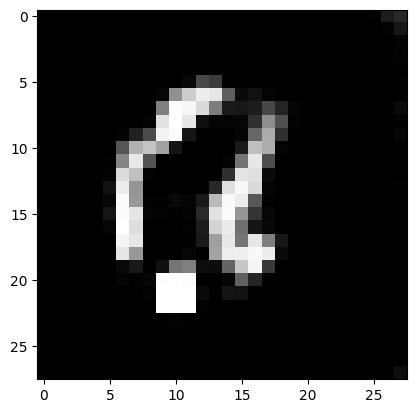

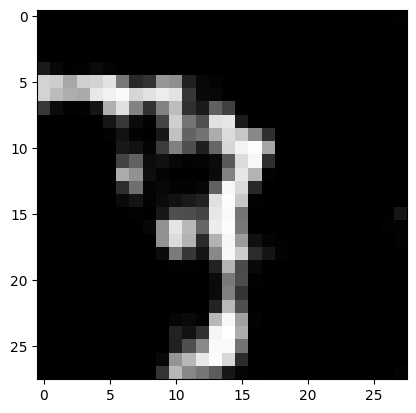

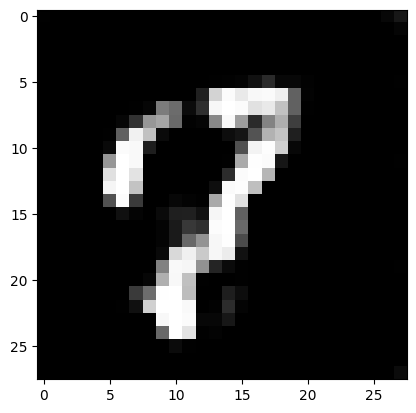

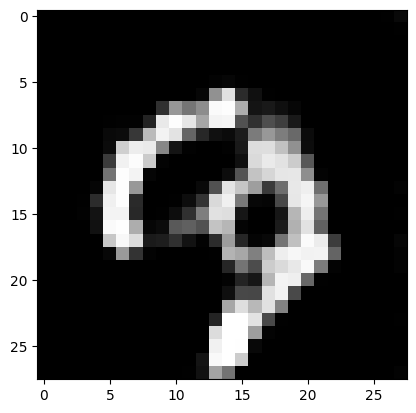

Client 9
Generating 640 fake images of digit 0 ......
Generating 640 fake images of digit 1 ......
Generating 640 fake images of digit 2 ......
Generating 640 fake images of digit 3 ......
Generating 640 fake images of digit 4 ......
Generating 640 fake images of digit 5 ......
Generating 640 fake images of digit 6 ......
Generating 640 fake images of digit 7 ......
Generating 640 fake images of digit 8 ......
Generating 640 fake images of digit 9 ......
Added (6400,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/5
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
462/462 [==============================] - 6s 8ms/step - sparse_categorical

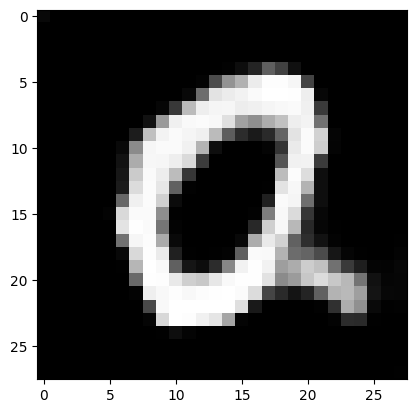

Global 0


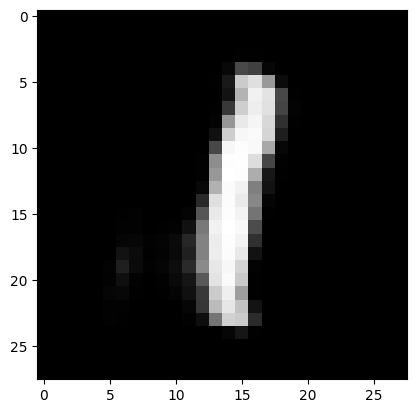

Global 1


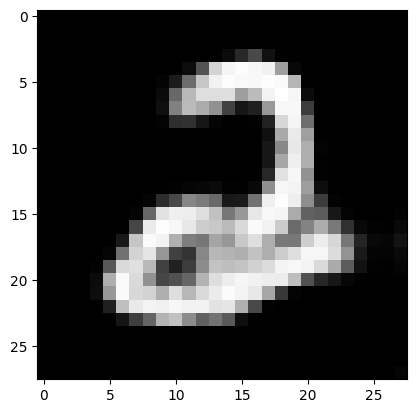

Global 2


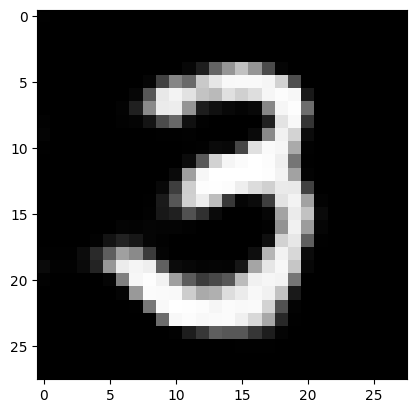

Global 3


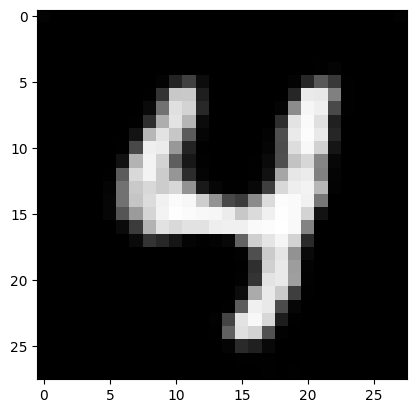

Global 4


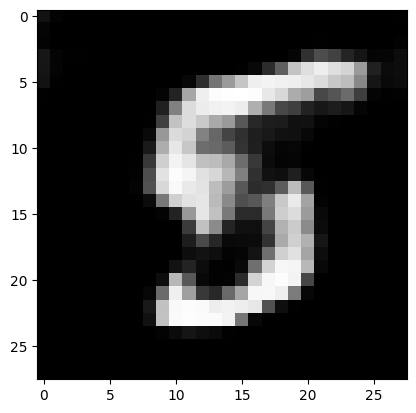

Global 5


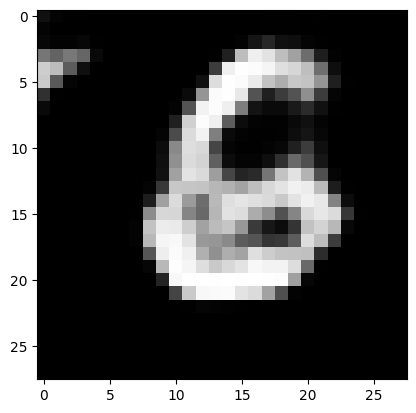

Global 6


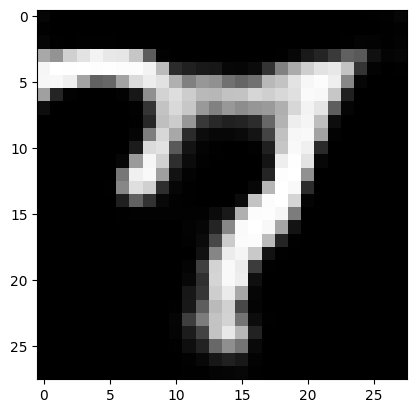

Global 7


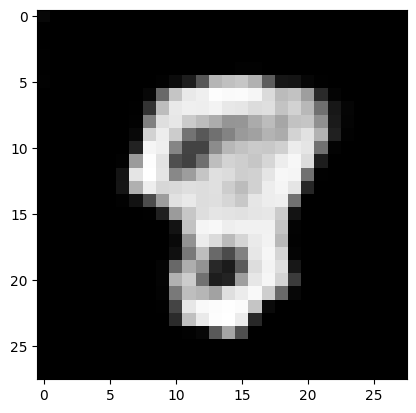

Global 8


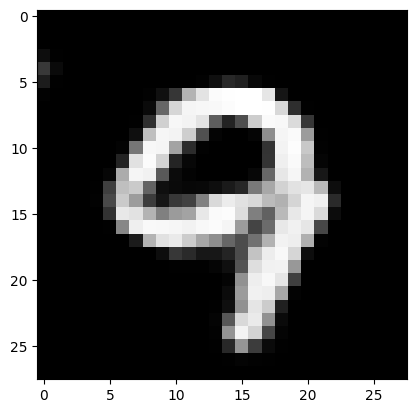

Global 9


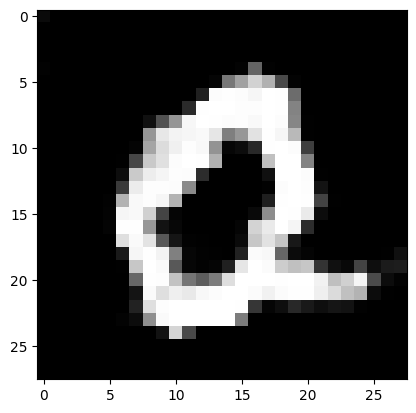

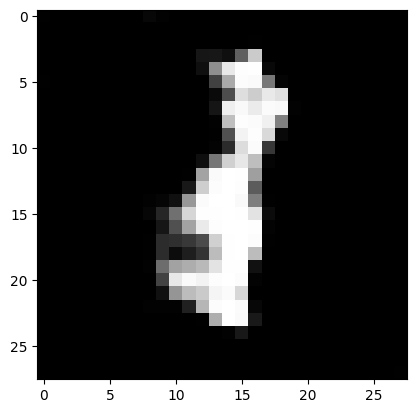

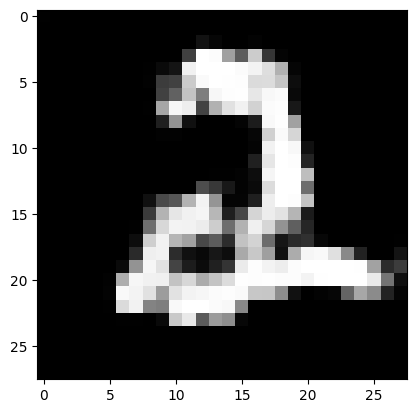

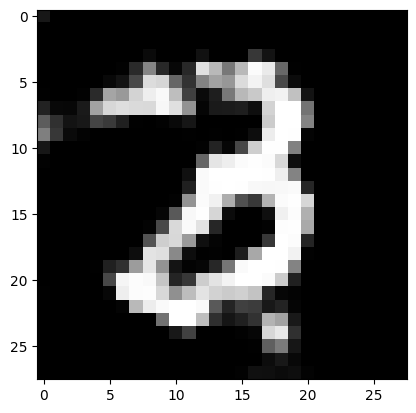

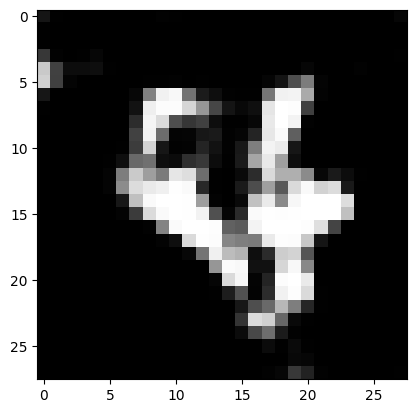

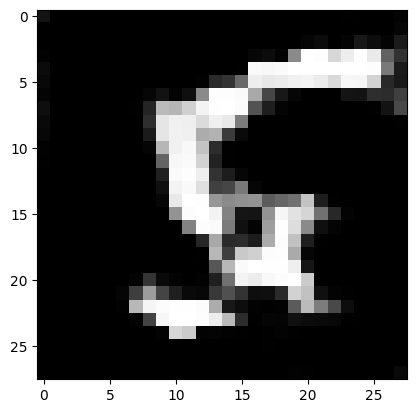

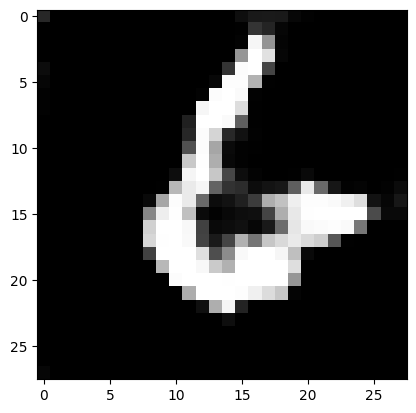

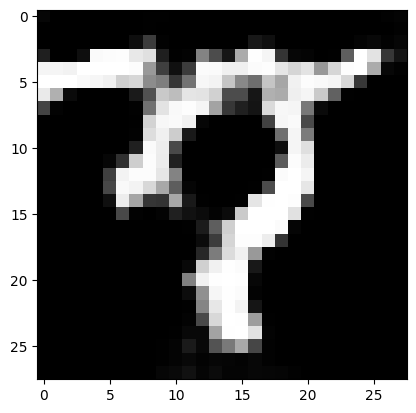

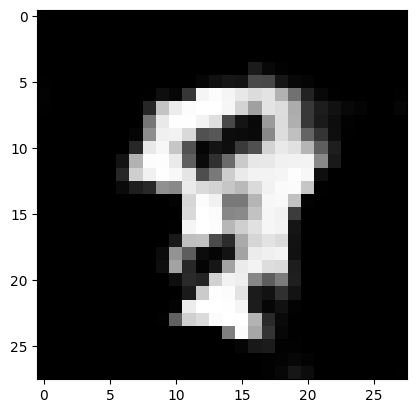

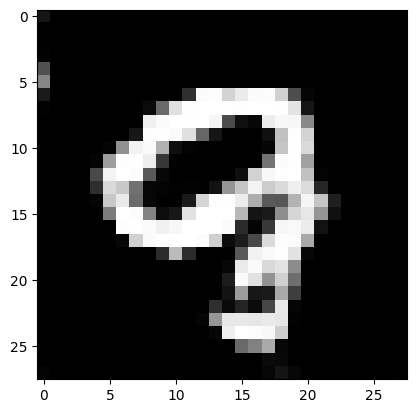

Client 9


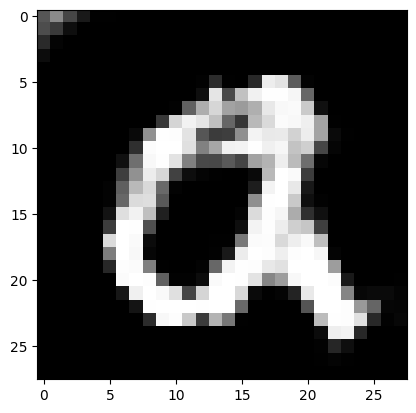

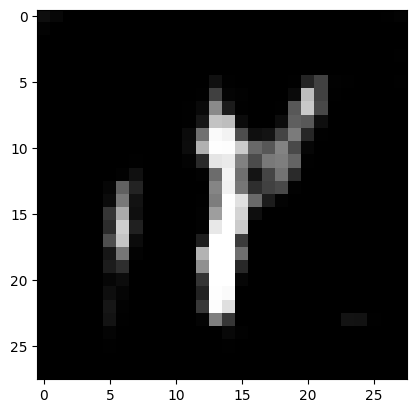

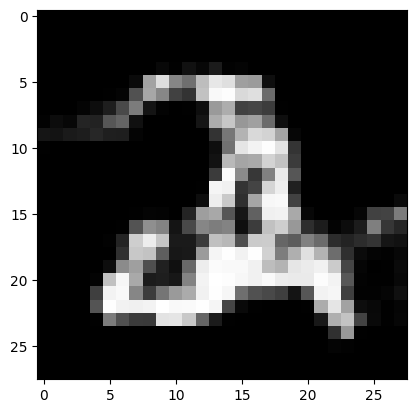

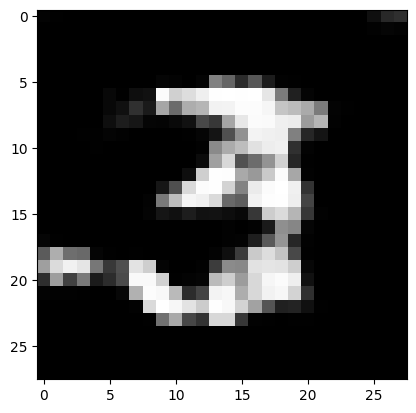

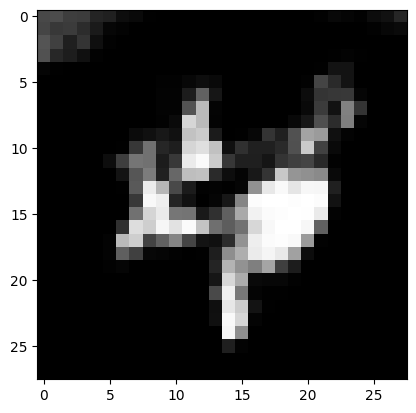

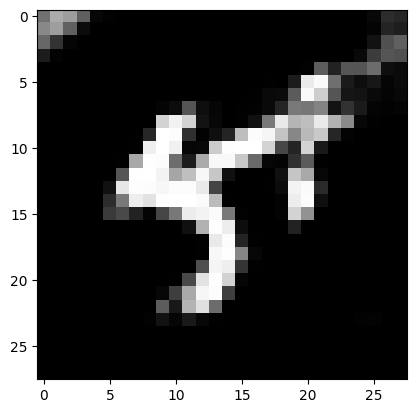

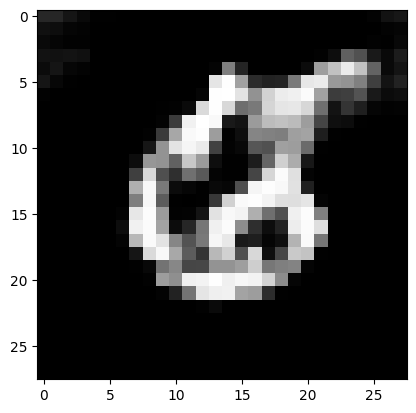

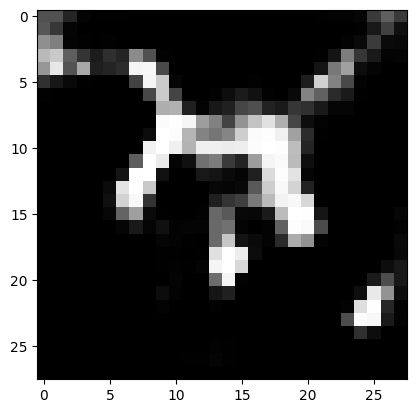

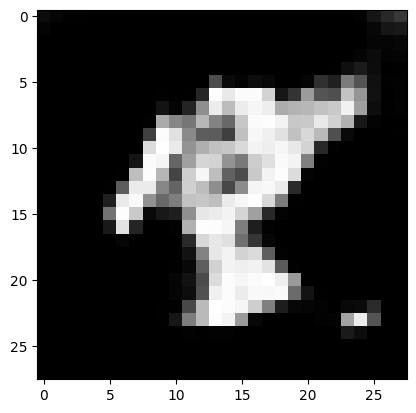

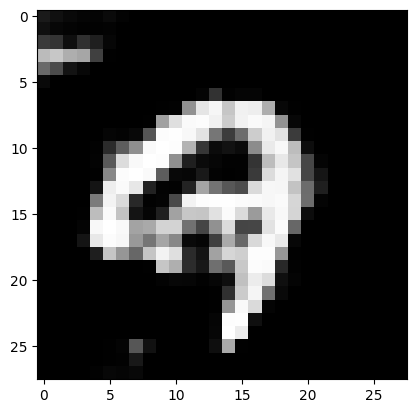

Client 9


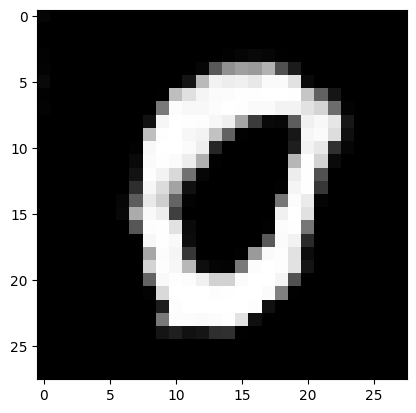

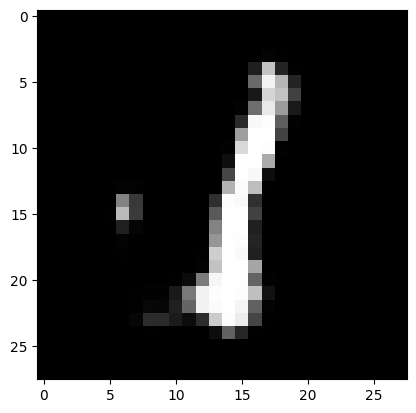

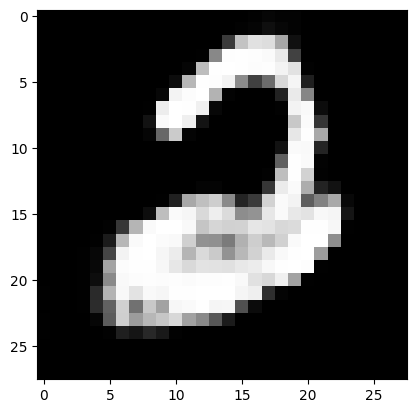

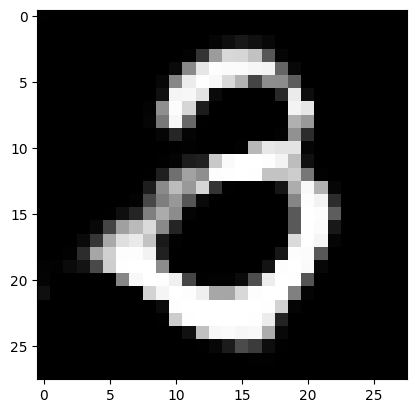

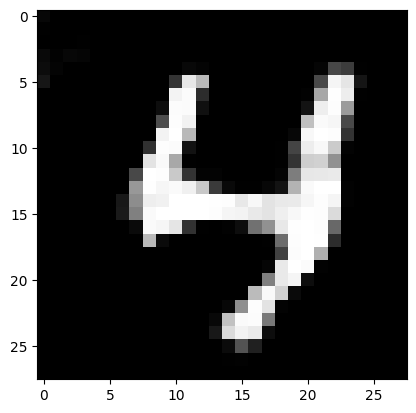

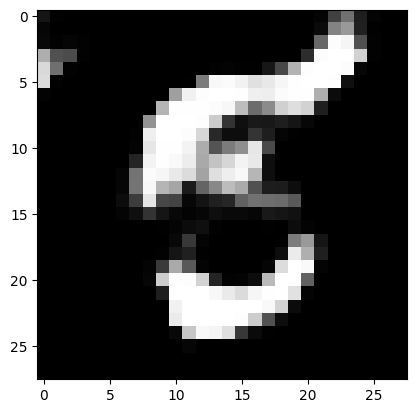

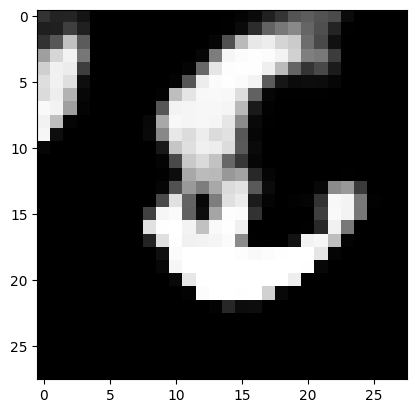

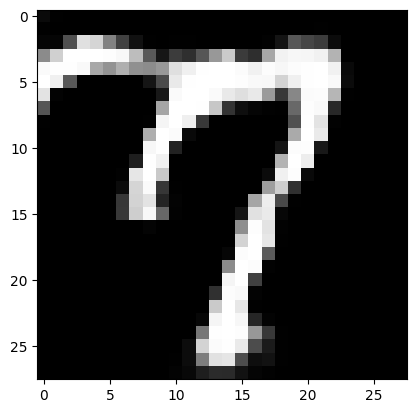

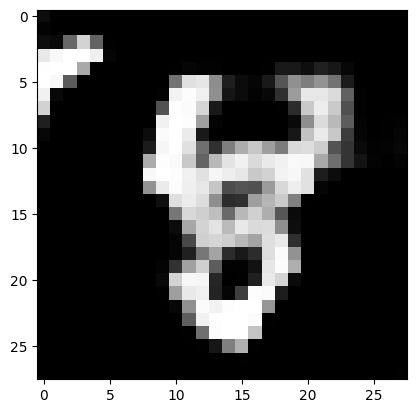

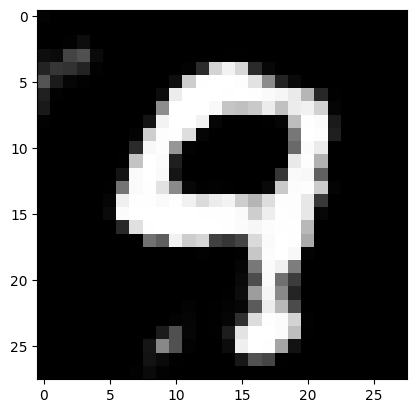

Client 9
Generating 640 fake images of digit 0 ......
Generating 640 fake images of digit 1 ......
Generating 640 fake images of digit 2 ......
Generating 640 fake images of digit 3 ......
Generating 640 fake images of digit 4 ......
Generating 640 fake images of digit 5 ......
Generating 640 fake images of digit 6 ......
Generating 640 fake images of digit 7 ......
Generating 640 fake images of digit 8 ......
Generating 640 fake images of digit 9 ......
Added (6400,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/5
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting client logits
----getting client logits
----getting client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
642/642 [==============================] - 6s 6ms/step - sparse_categorical

[0.09796255081892014, 0.9732899069786072]

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 6, algo='FedPKDG')

# Initialisation step
# train all local gan to a good performance (~convergence)
Server.local_training(cnn_epochs = 0, gen_epochs=15, is_earlystop=False)
print('********* ROUND0-initial local generator')
for client in client_list:
  for num in range(10):
    img = generate_image(client.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Client', num)
Server.agg_gen()
print('>>>>>>>>>Weighted aggregated client generator')

total_rounds = 3
for round in range(total_rounds):
  print('********* ROUND',round,'*********')
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')

  Server.local_training(gen_epochs=2, target_sparsity = target_sparsity, fine_tune_epochs=2)
  print('>>>>>>>>>trained all clients cnn round', round)

  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')

# to see the quality of generators
  for num in range(10):
    img = generate_image(Server.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Global', num)
  for client in client_list:
    for num in range(10):
      img = generate_image(client.generator, num, 128)
      plt.imshow(img[0], cmap='gray')
      plt.show()
    print('Client', num)

  Server.produce_pseudo_dataset(is_augment=False)
  print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

In [ ]:
def print_dist(y_train, name):
  unique, counts = np.unique(y_train, return_counts=True)
  label_distribution = dict(zip(unique, counts))
  # Print the label distribution
  print("Label Distribution in Training Set ", name, ":")
  for label, count in label_distribution.items():
      print(f"Label {label}: {count} instances")


print_dist(Server.y_public, 'server')

Label Distribution in Training Set  server :
Label 0: 2280 instances
Label 1: 2280 instances
Label 2: 2280 instances
Label 3: 2280 instances
Label 4: 2280 instances
Label 5: 2280 instances
Label 6: 2280 instances
Label 7: 2280 instances
Label 8: 2280 instances
Label 9: 2280 instances


# Experimentation

## Fedpkdg run script

In [36]:
def runpkdg(modelfn,client_list):
  # fedpkdg
  #initiate 1 server
  fedpkdg_Server = Server(modelfn, client_list, comm_freq = 5, algo='FedPKDG')

  # Initialisation step
  # train all local gan to a good performance (~convergence)
  fedpkdg_Server.local_training(cnn_epochs = 0, gen_epochs=10, is_earlystop=False)
  print('********* ROUND0-initial local generator')
  fedpkdg_Server.agg_gen()
  # print('>>>>>>>>>Weighted aggregated client generator')

  total_rounds = 20
  final_target_sparsity = 0.5
  accuracies = []
  clientacc=[[]for _ in range(10)]#10 clients
  clientloss=[[]for _ in range(10)]
  serveracc=[]
  serverloss=[]
  for round in range(1, total_rounds):
    print('********* ROUND',round,'*********')
    target_sparsity = final_target_sparsity*(round/total_rounds)
    alpha = 0.3
    fedpkdg_Server.broadcast()
    # print('>>>>>>>>>Broadcasted weights to all clients')
    if round==0:
      fedpkdg_Server.local_training(gen_epochs=2, cnn_epochs=15, target_sparsity = target_sparsity, fine_tune_epochs=2)
    else:
      fedpkdg_Server.local_training(gen_epochs=2, target_sparsity = target_sparsity, fine_tune_epochs=2)
    # print('>>>>>>>>>trained all clients cnn round', round)

    fedpkdg_Server.agg_gen()
    # print('>>>>>>>>>Weighted aggregated client generator')

    fedpkdg_Server.produce_pseudo_dataset(is_augment=True)
    # print('>>>>>>>>>produced pseudo data')

    fedpkdg_Server.distill_to_global(alpha=alpha)
    # print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

    # round evaluation
    for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
      accuracies.append(accuracy)

      clientacc[k].append(accuracy)
      clientloss[k].append(loss)
    print('ROUND',round, 'local models', accuracies[-10:], loss)

    print('global gen KID:', kid_score(fedpkdg_Server.generator))
    gloss, gaccuracy=fedpkdg_Server.cnn.evaluate(x_test, y_test, verbose=0)
    print('global CNN acc:', gaccuracy, gloss)
    serveracc.append(gaccuracy)
    serverloss.append(gloss)


  fedpkdg_Server.broadcast()
  # print('>>>>>>>>>Broadcasted weights to all clients')
  fedpkdg_Server.local_training(gen_epochs=0, target_sparsity = final_target_sparsity)
  print('>>>>>>>>>trained all clients cnn final round')

  for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
      accuracies.append(accuracy)

      clientacc[k].append(accuracy)
      clientloss[k].append(loss)
  print('FINAL ROUND local models', accuracies[-10:], loss)
  print('!!!!AVG client ACC', sum(accuracies[-10:])/10)
  print(clientacc)
  print(clientloss)
  print(serveracc)
  print(serverloss)
  client_avg_acc = np.sum(np.array(clientacc), axis=0)/10
  client_avg_loss = np.sum(np.array(clientloss), axis=0)/10
  serveracc=np.array(serveracc)
  serverloss=np.array(serverloss)
  # print('shapes',client_avg_acc.shape,serveracc.shape,client_avg_loss.shape,serverloss.shape)
  plot_fl_train(client_avg_acc,serveracc,client_avg_loss,serverloss)

## Test script - central, base, fedavg, fedpkdg

In [37]:
def run_test(modelfn,client_data): # centralised, baseline and FedAvg
  # centralised
  print('CENTRALISED START')
  centralised_model = modelfn
  centralised_model.compile(
          optimizer='adam',
          loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
        )

  centralised_model.fit(x_sample, y_sample, batch_size=batch_size, epochs=20,validation_split=0.1, callbacks=[early_stopping],verbose=0)
  loss, accuracy=centralised_model.evaluate(x_test, y_test, verbose=0)
  print('@@@@@@@@@@ centralised accuracy:',accuracy)

  # baseline
  # initiate client
  print('BASELINE START')
  client_list = []
  for k in range(10):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[k][0], client_data[k][1]))
  accuracies = []
  for client in client_list:
    client.train_cnn(epochs=30, early_stopping=True)
    loss, accuracy=client.cnn.evaluate(x_test, y_test, verbose=0)
    accuracies.append(accuracy)
  print('@@@@@@@@@@ baseline accuracy:',accuracies)
  print(sum(accuracies)/len(accuracies))

  # fedavg
  # initiate client
  print('FEDAVG START')
  client_list = []
  for i in range(10):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[i][0], client_data[i][1]))
  fedavgserver = Server(modelfn, client_list, comm_freq = 5)

  clientacc=[[]for _ in range(10)]#10 clients
  clientloss=[[]for _ in range(10)]
  serveracc=[]
  serverloss=[]

  for _ in range(20):
    print('FedAvg Round',_)
    fedavgserver.broadcast()
    # print('Broadcasted weights to all clients')
    fedavgserver.local_training()
    # print('trained all clients cnn round', _)
    currclientacc=[]
    for k, client in enumerate(client_list):
      loss, accuracy=client.cnn.evaluate(x_test, y_test,verbose=0)
      currclientacc.append(accuracy)
      clientacc[k].append(accuracy)
      clientloss[k].append(loss)
    print(currclientacc)

    fedavgserver.agg_cnn()

    # print('Weighted aggregated client weights')
    loss, accuracy=fedavgserver.cnn.evaluate(x_test, y_test,verbose=0)
    serveracc.append(accuracy)
    serverloss.append(loss)
    print('global:',accuracy)

  print(clientacc)
  print(clientloss)
  print(serveracc)
  print(serverloss)
  client_avg_acc = np.sum(np.array(clientacc), axis=0)/10
  client_avg_loss = np.sum(np.array(clientloss), axis=0)/10
  serveracc=np.array(serveracc)
  serverloss=np.array(serverloss)
  # print('shapes',client_avg_acc.shape,serveracc.shape,client_avg_loss.shape,serverloss.shape)
  plot_fl_train(client_avg_acc,serveracc,client_avg_loss,serverloss)
  avg_client_acc=0
  for k in range(10):
    avg_client_acc+=clientacc[k][-1]/10
  print('@@@@@@@@@@ avg client acc', avg_client_acc)

  #fedpkdg
  print('FEDPKDG START')
  client_list = []
  for i in range(10):
    #partition dataset to mimic private data
    client_list.append(Client(modelfn, client_data[i][0], client_data[i][1]))
  runpkdg(modelfn,client_list)

## homogeneous - 10 uniform clients

### r=0.25 done not fedpkdg

In [159]:
#take sampled data
x_sample, y_sample=sample_training_data(0.25)
print_dist(y_sample,'0.25')
#initiate client data - uniform
no_sample = len(x_sample) // 10
client_data = []
for i in range(10):
  #partition dataset to mimic private data
  x_train_k = x_sample[no_sample*i:no_sample*(i+1)]
  y_train_k = y_sample[no_sample*i:no_sample*(i+1)]
  client_data.append([x_train_k, y_train_k])

Label Distribution in Training Set  0.25 :
Label 0: 1477 instances
Label 1: 1718 instances
Label 2: 1521 instances
Label 3: 1499 instances
Label 4: 1432 instances
Label 5: 1317 instances
Label 6: 1494 instances
Label 7: 1544 instances
Label 8: 1493 instances
Label 9: 1505 instances


Epoch 12: early stopping
@@@@@@@@@@ centralised accuracy: 0.9674000144004822
@@@@@@@@@@ baseline accuracy: [0.9646999835968018, 0.9621000289916992, 0.9602000117301941, 0.9611999988555908, 0.9613999724388123, 0.9639999866485596, 0.9621000289916992, 0.9639999866485596, 0.9648000001907349, 0.9631999731063843]
0.9627699971199035
[[0.9692999720573425, 0.9690999984741211, 0.9696000218391418, 0.9697999954223633, 0.9696999788284302, 0.9692000150680542, 0.9692999720573425, 0.9702000021934509, 0.9696000218391418, 0.9689000248908997, 0.9693999886512756, 0.9696999788284302, 0.9696000218391418, 0.9697999954223633, 0.9688000082969666], [0.9692999720573425, 0.9690999984741211, 0.9696000218391418, 0.9697999954223633, 0.9696999788284302, 0.9692000150680542, 0.9692999720573425, 0.9702000021934509, 0.9696000218391418, 0.9689000248908997, 0.9693999886512756, 0.9696999788284302, 0.9696000218391418, 0.9697999954223633, 0.9688000082969666], [0.9692999720573425, 0.9690999984741211, 0.9696000218391418, 0.96979

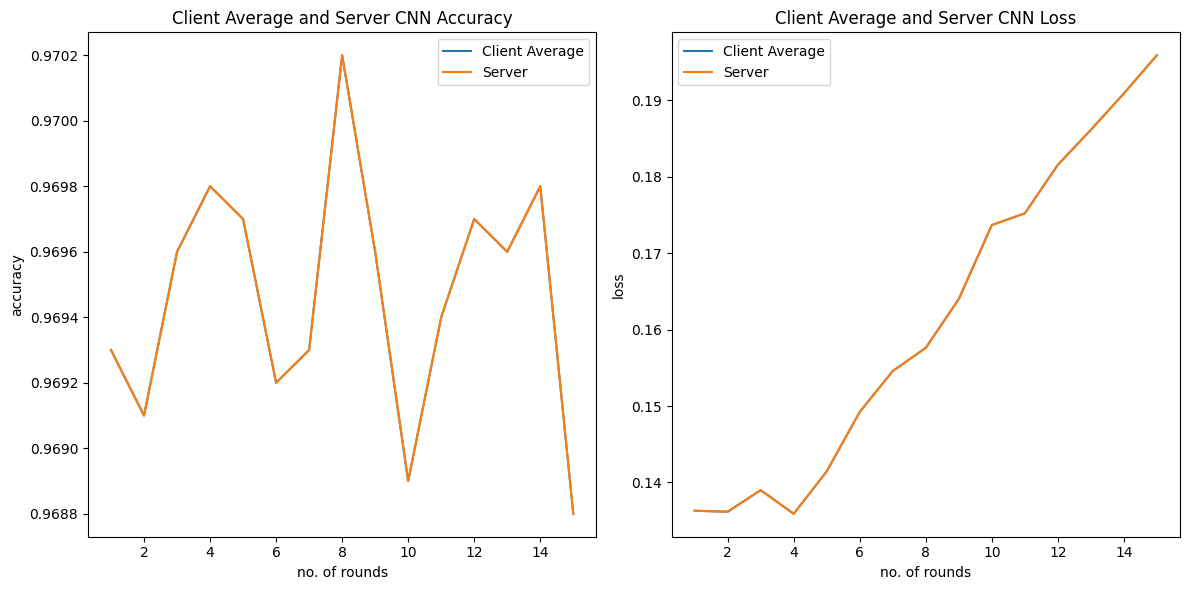

@@@@@@@@@@ avg client acc 0.9688000082969663


In [160]:
run_test(smallCNN(),client_data)

### r=0.1

In [182]:
x_sample, y_sample=sample_training_data(0.1)
print_dist(y_sample,'0.1')
#initiate client data - uniform
no_sample = len(x_sample) // 10
client_data = []
for i in range(10):
  #partition dataset to mimic private data
  x_train_k = x_sample[no_sample*i:no_sample*(i+1)]
  y_train_k = y_sample[no_sample*i:no_sample*(i+1)]
  client_data.append([x_train_k, y_train_k])

Label Distribution in Training Set  0.1 :
Label 0: 589 instances
Label 1: 674 instances
Label 2: 589 instances
Label 3: 578 instances
Label 4: 584 instances
Label 5: 530 instances
Label 6: 609 instances
Label 7: 623 instances
Label 8: 625 instances
Label 9: 599 instances


Epoch 11: early stopping
@@@@@@@@@@ centralised accuracy: 0.9368000030517578
@@@@@@@@@@ baseline accuracy: [0.9305999875068665, 0.9334999918937683, 0.9351000189781189, 0.9394000172615051, 0.9373999834060669, 0.9304999709129333, 0.9455999732017517, 0.9451000094413757, 0.9437999725341797, 0.9372000098228455]
0.9378199934959411
[[0.9456999897956848, 0.9490000009536743, 0.9498000144958496, 0.9508000016212463, 0.9519000053405762, 0.9528999924659729, 0.9528999924659729, 0.9549999833106995, 0.9542999863624573, 0.9577000141143799, 0.9578999876976013, 0.9595000147819519, 0.9588000178337097, 0.9577999711036682, 0.9585999846458435], [0.9456999897956848, 0.9490000009536743, 0.9498000144958496, 0.9508000016212463, 0.9519000053405762, 0.9528999924659729, 0.9528999924659729, 0.9549999833106995, 0.9542999863624573, 0.9577000141143799, 0.9578999876976013, 0.9595000147819519, 0.9588000178337097, 0.9577999711036682, 0.9585999846458435], [0.9456999897956848, 0.9490000009536743, 0.9498000144958496, 0.95080

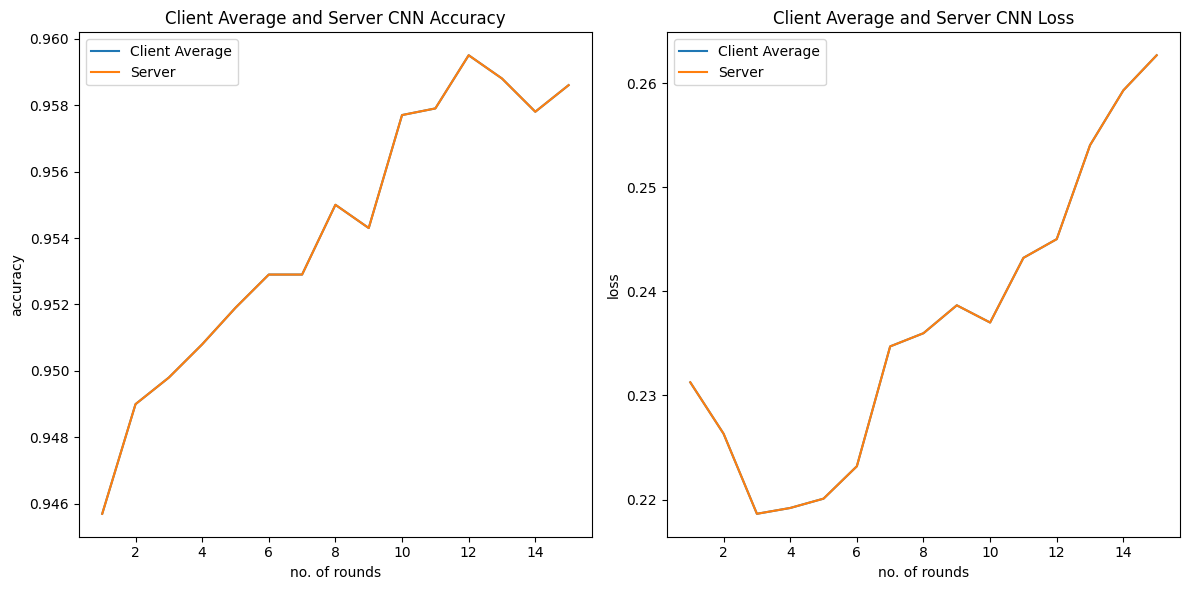

@@@@@@@@@@ avg client acc 0.9585999846458436


In [183]:
run_test(smallCNN(),client_data)

#### FedPKDG
distill 5 epochs with alpha = 0.3

In [44]:
x_sample, y_sample=sample_training_data(0.1)
print_dist(y_sample,'0.1')
#initiate client data - uniform
no_sample = len(x_sample) // 10
client_data = []
for i in range(10):
  #partition dataset to mimic private data
  x_train_k = x_sample[no_sample*i:no_sample*(i+1)]
  y_train_k = y_sample[no_sample*i:no_sample*(i+1)]
  client_data.append([x_train_k, y_train_k])


Label Distribution in Training Set  0.1 :
Label 0: 589 instances
Label 1: 674 instances
Label 2: 589 instances
Label 3: 578 instances
Label 4: 584 instances
Label 5: 530 instances
Label 6: 609 instances
Label 7: 623 instances
Label 8: 625 instances
Label 9: 599 instances


In [45]:
client_list = []
for i in range(10):
  #partition dataset to mimic private data
  client_list.append(Client(smallCNN(), client_data[i][0], client_data[i][1]))

In [26]:
runpkdg()

********* ROUND0-initial local generator
********* ROUND 0 *********
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
Augmented dataset shape: (300, 28, 28, 1), (300,)
Added (600,) data points to the public dataset
ROUND 0 local models [0.7444000244140625, 0.7793999910354614, 0.7480000257492065, 0.766700029373169, 0.7534000277519226, 0.7501999735832214, 0.7549999952316284, 0.739799976348877, 0.7429999709129333, 0.7335000038146973]
********* ROUND 1 *********
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsit

In [46]:
runpkdg()

********* ROUND0-initial local generator
********* ROUND 0 *********
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
CNN target sparsity 0.0
Augmented dataset shape: (300, 28, 28, 1), (300,)
Added (600,) data points to the public dataset
ROUND 0 local models [0.7771999835968018, 0.7904999852180481, 0.7876999974250793, 0.7918000221252441, 0.77920001745224, 0.7696999907493591, 0.7990000247955322, 0.7710999846458435, 0.7781999707221985, 0.7746000289916992] 0.7774960398674011
Added (100,) data points to the public dataset
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
KID score: 0.3437481445312498
global gen KID: None
global CNN acc: 0.7746000289916992 0.7774960398674011
********* ROUND 1 *********
CNN target sparsity 0.016666666666666666
CNN target sparsity 0.016666666666666666
CNN target sparsity

KeyboardInterrupt: 

In [31]:
#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 10, algo='FedPKDG')
# Initialisation step
# train all local gan to a good performance (~convergence)
Server.local_training(cnn_epochs = 0, gen_epochs=10, is_earlystop=False)
print('********* ROUND0-initial local generator')
Server.agg_gen()
print('>>>>>>>>>Weighted aggregated client generator')

total_rounds = 10
final_target_sparsity = 0.5
for round in range(total_rounds):
  print('********* ROUND',round,'*********')
  target_sparsity = final_target_sparsity*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')

  Server.local_training(gen_epochs=2, target_sparsity = target_sparsity, fine_tune_epochs=2)
  print('>>>>>>>>>trained all clients cnn round', round)

  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')

  Server.produce_pseudo_dataset(is_augment=False)
  print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training(gen_epochs=0, target_sparsity = final_target_sparsity)
print('>>>>>>>>>trained all clients cnn final round')
accuracies = []
for client in client_list:
  loss, accuracy=client.cnn.evaluate(x_test, y_test)
  accuracies.append(accuracy)
print('local models', accuracies)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)
print('avg client acc', sum(accuracies)/len(accuracies))

training client 0 's CNN
training client 0 's GEN
training client 1 's CNN
training client 1 's GEN
training client 2 's CNN
training client 2 's GEN
training client 3 's CNN
training client 3 's GEN
training client 4 's CNN
training client 4 's GEN
training client 5 's CNN
training client 5 's GEN
training client 6 's CNN
training client 6 's GEN
training client 7 's CNN
training client 7 's GEN
training client 8 's CNN
training client 8 's GEN
training client 9 's CNN
training client 9 's GEN
********* ROUND0-initial local generator
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
********* ROUND 0 *********
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 168 end_step= 841 target_sparsity= 0.0
after pruning client has sparsity 0.0
training client 0 's GEN
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.00565955594253

#### FedPKDG - with augmentation, changing alpha

In [51]:
#initiate 1 server
Server = Server(smallCNN(), client_list, algo='FedPKDG')
# Initialisation step
# train all local gan to a good performance
Server.local_training(cnn_epochs = 0, gen_epochs=10)
print('********* ROUND0-initial local generator')
Server.agg_gen()
# print('>>>>>>>>>Weighted aggregated client generator')

total_rounds = 10
final_target_sparsity = 0.5
accuracies = []
for round in range(total_rounds):
  print('********* ROUND',round,'*********')
  target_sparsity = final_target_sparsity*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')

  Server.local_training(gen_epochs=2, target_sparsity = target_sparsity, fine_tune_epochs=2)
  print('>>>>>>>>>trained all clients cnn round', round)

  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')

  Server.produce_pseudo_dataset(is_augment=True)
  print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global(alpha=alpha)
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

  for client in client_list:
    loss, accuracy=client.cnn.evaluate(x_test, y_test)
    accuracies.append(accuracy)
  print('ROUND',round, 'local models', accuracies[-10:])

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training(gen_epochs=0, target_sparsity = final_target_sparsity)
print('>>>>>>>>>trained all clients cnn final round')

for client in client_list:
  loss, accuracy=client.cnn.evaluate(x_test, y_test)
  accuracies.append(accuracy)
print('local models', accuracies[-10:])
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)
print('avg client acc', sum(accuracies)/len(accuracies))

training client 0 's CNN
training client 0 's GEN
training client 1 's CNN
training client 1 's GEN
training client 2 's CNN
training client 2 's GEN
training client 3 's CNN
training client 3 's GEN
training client 4 's CNN
training client 4 's GEN
training client 5 's CNN
training client 5 's GEN
training client 6 's CNN
training client 6 's GEN
training client 7 's CNN
training client 7 's GEN
training client 8 's CNN
training client 8 's GEN
training client 9 's CNN
training client 9 's GEN
********* ROUND0-initial local generator
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
********* ROUND 0 *********
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 168 end_step= 841 target_sparsity= 0.0
after pruning client has sparsity 0.0
training client 0 's GEN
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.00565955594253

In [55]:
sum([0.9589999914169312, 0.9531000256538391, 0.9584000110626221, 0.9564999938011169, 0.9549999833106995, 0.9591000080108643, 0.960099995136261, 0.9526000022888184, 0.9513999819755554, 0.9520000219345093])/10

0.9557200014591217

## Heterogenous - 10 dirichlet clients

### test script

### r=0.25

In [207]:
#take sampled data
x_sample, y_sample=sample_training_data(0.25)
print_dist(y_sample,'0.25')

Label Distribution in Training Set  0.25 :
Label 0: 1477 instances
Label 1: 1718 instances
Label 2: 1521 instances
Label 3: 1499 instances
Label 4: 1432 instances
Label 5: 1317 instances
Label 6: 1494 instances
Label 7: 1544 instances
Label 8: 1493 instances
Label 9: 1505 instances


#### dir_alpha=0.5

Client 1: 1498 samples
Client 2: 1349 samples
Client 3: 1216 samples
Client 4: 1094 samples
Client 5: 983 samples
Client 6: 591 samples
Client 7: 752 samples
Client 8: 694 samples
Client 9: 617 samples
Client 10: 572 samples
[[ 48  26 166 114   7 358  11 404 295  69]
 [173 100  57   4 198  41 256 360  16 144]
 [ 62 195   1  20  34   1  36  87 779   1]
 [  8  48  64  24 122  21   9 275 147 376]
 [143  73   2 115 138 206 123  10 137  36]
 [  1 353   1   7  13  81   1  10 119   5]
 [ 22 329   3  58   1  31   1 303   0   4]
 [125   6  10  75 243 101  52  67   0  15]
 [  3  47   9   3   0   6 274  28   0 247]
 [ 22  80 108  49   4 285  22   0   0   2]]


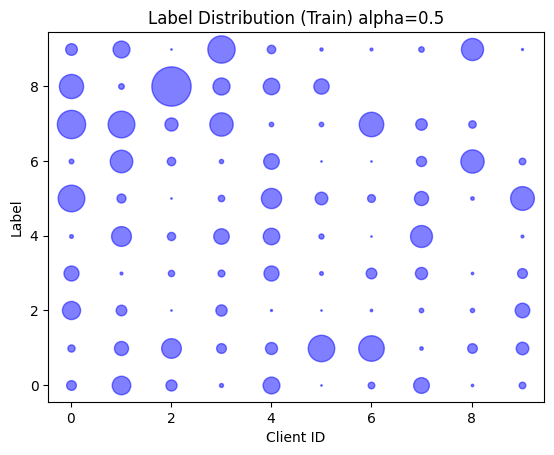

In [208]:
# generate client split
dir_alpha=0.5 # to change for different runs
client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha)
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(x)} samples")
# Plot the bubble chart with normalized sizes
plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)

Epoch 17: early stopping
@@@@@@@@@@ centralised accuracy: 0.9672999978065491
@@@@@@@@@@ baseline accuracy: [0.8780999779701233, 0.9323999881744385, 0.838100016117096, 0.9557999968528748, 0.9236999750137329, 0.8626000285148621, 0.832099974155426, 0.8036999702453613, 0.8967000246047974, 0.8603000044822693]
0.8783499956130981
[[0.8858000040054321, 0.9107999801635742, 0.8946999907493591, 0.8840000033378601, 0.9018999934196472, 0.9003000259399414, 0.8980000019073486, 0.892300009727478, 0.8798999786376953, 0.8946999907493591, 0.8925999999046326, 0.8946999907493591, 0.8944000005722046, 0.8896999955177307, 0.885699987411499], [0.8858000040054321, 0.9107999801635742, 0.8946999907493591, 0.8840000033378601, 0.9018999934196472, 0.9003000259399414, 0.8980000019073486, 0.892300009727478, 0.8798999786376953, 0.8946999907493591, 0.8925999999046326, 0.8946999907493591, 0.8944000005722046, 0.8896999955177307, 0.885699987411499], [0.8858000040054321, 0.9107999801635742, 0.8946999907493591, 0.88400000333

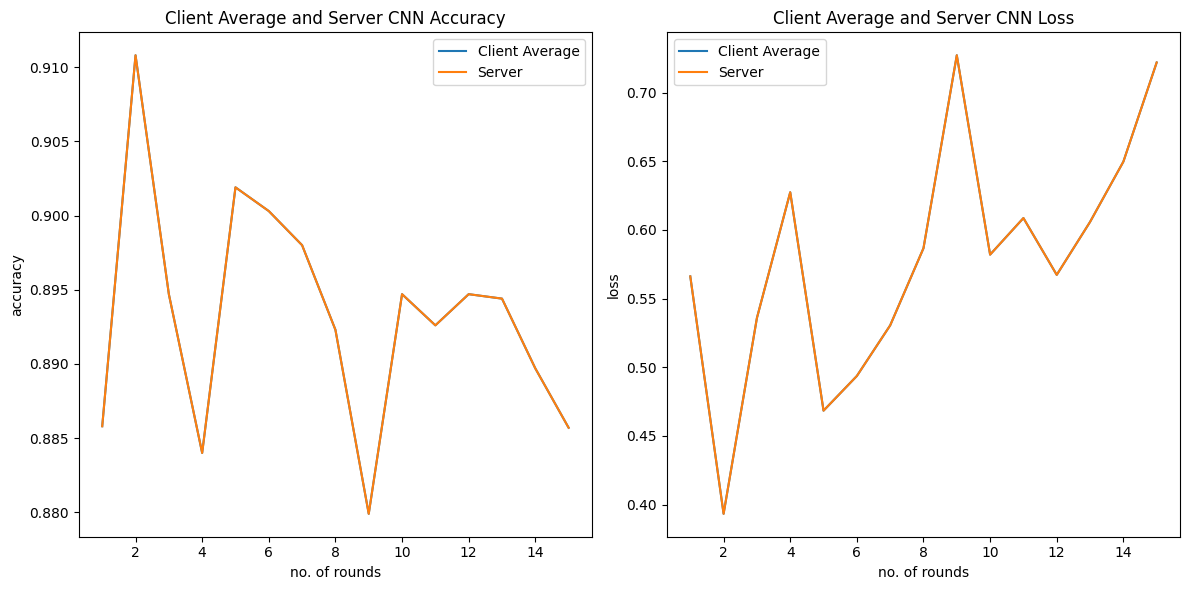

@@@@@@@@@@ avg client acc 0.885699987411499


In [209]:
run_test(smallCNN(),client_data)

####dir_alpha=0.1

Client 1: 1500 samples
Client 2: 1332 samples
Client 3: 1215 samples
Client 4: 1095 samples
Client 5: 722 samples
Client 6: 912 samples
Client 7: 537 samples
Client 8: 766 samples
Client 9: 415 samples
Client 10: 565 samples
[[1443    0    0    0    0    0   22   33    2    0]
 [  34    1    0    0    2   84 1008    0    8  195]
 [   0    0    0    2  476    0    0    5  732    0]
 [   0    0    1    1    0    0    9  854  230    0]
 [   0  490    0   94    0   95    0   38    5    0]
 [   0    0    0   31   17  656    0   18  190    0]
 [   0    0    0   15    0   15    2    0  326  179]
 [   0  204  524    0    0   11   17    0    0   10]
 [   0    2   63  320    0    2   26    0    0    2]
 [   0   80    1    0    0  454    0    1    0   29]]


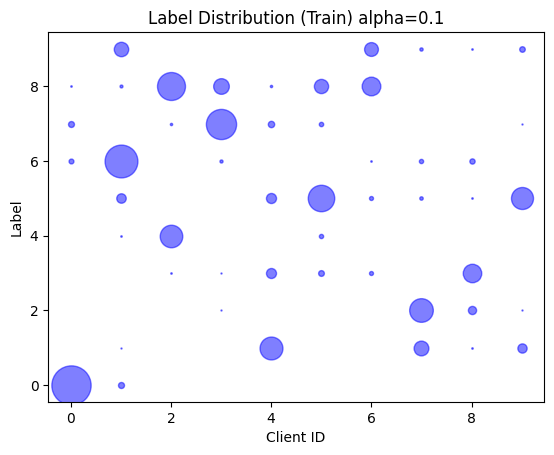

In [211]:
# generate client split
dir_alpha=0.1 # to change for different runs
client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha)
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(x)} samples")
# Plot the bubble chart with normalized sizes
plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)

Epoch 9: early stopping
@@@@@@@@@@ centralised accuracy: 0.9628000259399414
@@@@@@@@@@ baseline accuracy: [0.8567000031471252, 0.7260000109672546, 0.5794000029563904, 0.5778999924659729, 0.7347999811172485, 0.6669999957084656, 0.6258999705314636, 0.6424999833106995, 0.567300021648407, 0.5281999707221985]
0.6505699932575226
[[0.6193000078201294, 0.5728999972343445, 0.5465999841690063, 0.5274999737739563, 0.49059998989105225, 0.5058000087738037, 0.4984000027179718, 0.49149999022483826, 0.4932999908924103, 0.5034000277519226, 0.5016000270843506, 0.5482000112533569, 0.545799970626831, 0.5443000197410583, 0.5551000237464905], [0.6193000078201294, 0.5728999972343445, 0.5465999841690063, 0.5274999737739563, 0.49059998989105225, 0.5058000087738037, 0.4984000027179718, 0.49149999022483826, 0.4932999908924103, 0.5034000277519226, 0.5016000270843506, 0.5482000112533569, 0.545799970626831, 0.5443000197410583, 0.5551000237464905], [0.6193000078201294, 0.5728999972343445, 0.5465999841690063, 0.52749

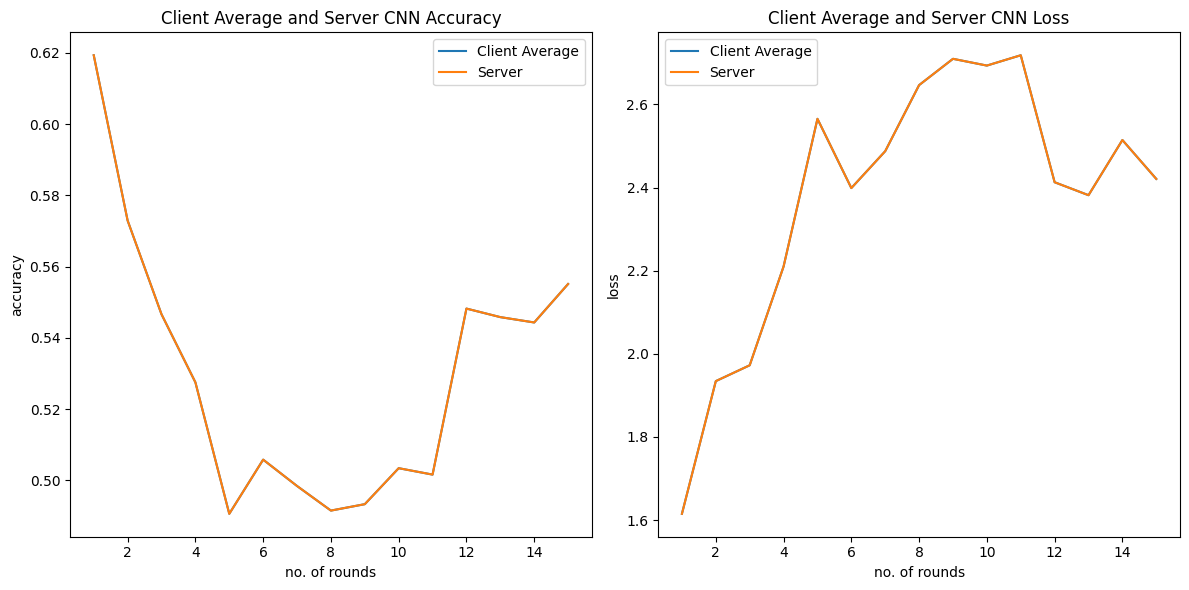

@@@@@@@@@@ avg client acc 0.5551000237464905


In [212]:
run_test(smallCNN(),client_data)

####dir_alpha=0.05

Client 1: 1500 samples
Client 2: 1091 samples
Client 3: 1098 samples
Client 4: 1132 samples
Client 5: 1017 samples
Client 6: 362 samples
Client 7: 831 samples
Client 8: 15 samples
Client 9: 764 samples
Client 10: 690 samples
[[ 315    0    0  571   12  229   37    2    0  334]
 [   0    0    0    0    0 1088    0    0    0    3]
 [ 869    2  227    0    0    0    0    0    0    0]
 [  81    9    0    0    1    0    0 1041    0    0]
 [   0 1014    0    0    1    0    0    0    0    2]
 [   0  360    1    0    0    0    0    0    1    0]
 [ 212   61    0    8  550    0    0    0    0    0]
 [   0   14    0    0    0    0    1    0    0    0]
 [   0    0  168  582    0    0    8    6    0    0]
 [   0  258    0    0    2    0    0    0    0  430]]


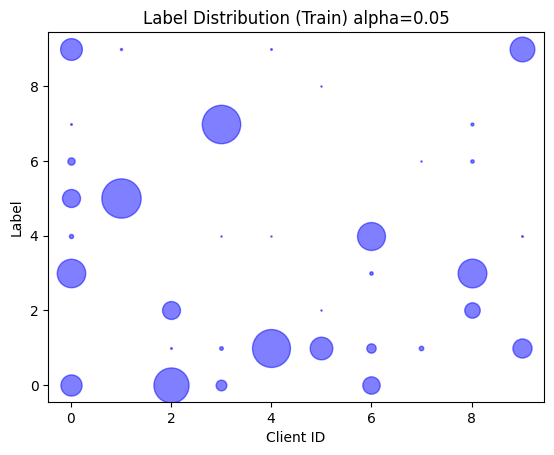

Epoch 14: early stopping
@@@@@@@@@@ centralised accuracy: 0.9692999720573425
@@@@@@@@@@ baseline accuracy: [0.7681999802589417, 0.46810001134872437, 0.7886000275611877, 0.7475000023841858, 0.6758000254631042, 0.6172999739646912, 0.6791999936103821, 0.7214000225067139, 0.6299999952316284, 0.7197999954223633]
0.6815900027751922
[[0.7870000004768372, 0.7702999711036682, 0.7547000050544739, 0.715399980545044, 0.756600022315979, 0.7250000238418579, 0.7379999756813049, 0.7296000123023987, 0.7372999787330627, 0.7027000188827515, 0.718999981880188, 0.7146000266075134, 0.7014999985694885, 0.6942999958992004, 0.6901999711990356], [0.7870000004768372, 0.7702999711036682, 0.7547000050544739, 0.715399980545044, 0.756600022315979, 0.7250000238418579, 0.7379999756813049, 0.7296000123023987, 0.7372999787330627, 0.7027000188827515, 0.718999981880188, 0.7146000266075134, 0.7014999985694885, 0.6942999958992004, 0.6901999711990356], [0.7870000004768372, 0.7702999711036682, 0.7547000050544739, 0.7153999805

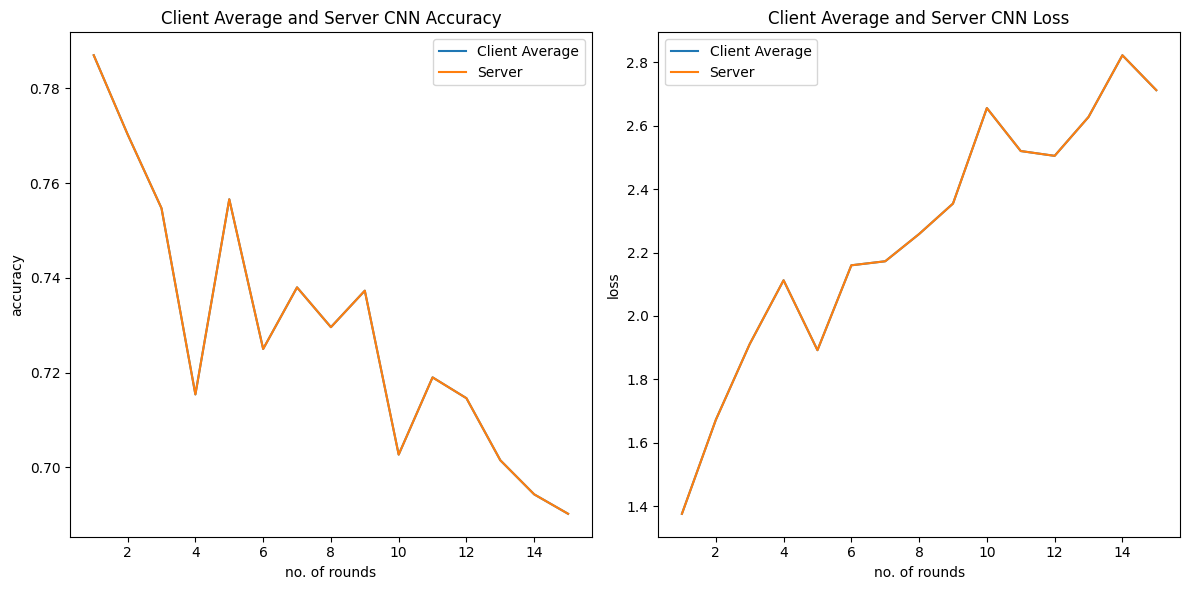

@@@@@@@@@@ avg client acc 0.6901999711990358


In [214]:
# generate client split
dir_alpha=0.05 # to change for different runs
client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha)
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(x)} samples")
# Plot the bubble chart with normalized sizes
plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)
run_test(smallCNN(),client_data)

###r=0.1

In [215]:
#take sampled data
x_sample, y_sample=sample_training_data(0.1)
print_dist(y_sample,'0.1')

Label Distribution in Training Set  0.1 :
Label 0: 589 instances
Label 1: 674 instances
Label 2: 589 instances
Label 3: 578 instances
Label 4: 584 instances
Label 5: 530 instances
Label 6: 609 instances
Label 7: 623 instances
Label 8: 625 instances
Label 9: 599 instances


Client 1: 601 samples
Client 2: 541 samples
Client 3: 486 samples
Client 4: 438 samples
Client 5: 394 samples
Client 6: 354 samples
Client 7: 318 samples
Client 8: 240 samples
Client 9: 262 samples
Client 10: 162 samples
[[ 25  56  19   3  44  42 216  19  25 152]
 [  0   2 115 186   2  40  73 104   8  11]
 [ 47  35  24  11 272   5  68   4   5  15]
 [131   2  33  57  15  63  11   1  11 114]
 [  9  28  59  26   0  80 140  32   1  19]
 [ 14  34  24  12  13  20   9 124 104   0]
 [  0   0  33  22  24   8  92   0 104  35]
 [  2   0   2  77   2   0   0   1 153   3]
 [ 12  10   1   8   0   4   0  13 213   1]
 [  8  33  12   0   7  49   0  40   1  12]]


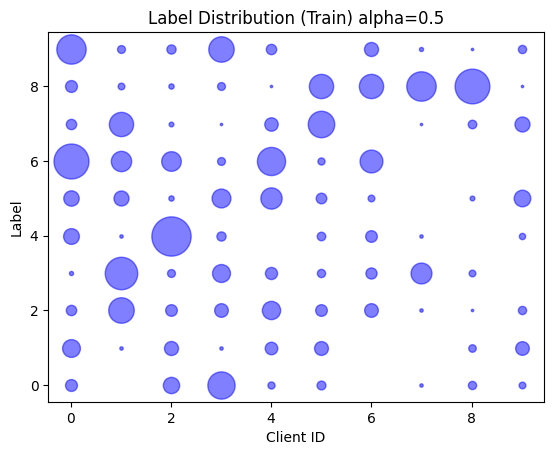

Epoch 14: early stopping
@@@@@@@@@@ centralised accuracy: 0.9491000175476074
@@@@@@@@@@ baseline accuracy: [0.9192000031471252, 0.829200029373169, 0.8046000003814697, 0.9189000129699707, 0.819100022315979, 0.8701000213623047, 0.8738999962806702, 0.7124999761581421, 0.8213000297546387, 0.7825000286102295]
0.8351300120353699
[[0.8309999704360962, 0.84579998254776, 0.8802000284194946, 0.8626999855041504, 0.8866000175476074, 0.8802000284194946, 0.8871999979019165, 0.8960000276565552, 0.8902000188827515, 0.8968999981880188, 0.909500002861023, 0.8963000178337097, 0.9067999720573425, 0.8921999931335449, 0.8999999761581421], [0.8309999704360962, 0.84579998254776, 0.8802000284194946, 0.8626999855041504, 0.8866000175476074, 0.8802000284194946, 0.8871999979019165, 0.8960000276565552, 0.8902000188827515, 0.8968999981880188, 0.909500002861023, 0.8963000178337097, 0.9067999720573425, 0.8921999931335449, 0.8999999761581421], [0.8309999704360962, 0.84579998254776, 0.8802000284194946, 0.862699985504150

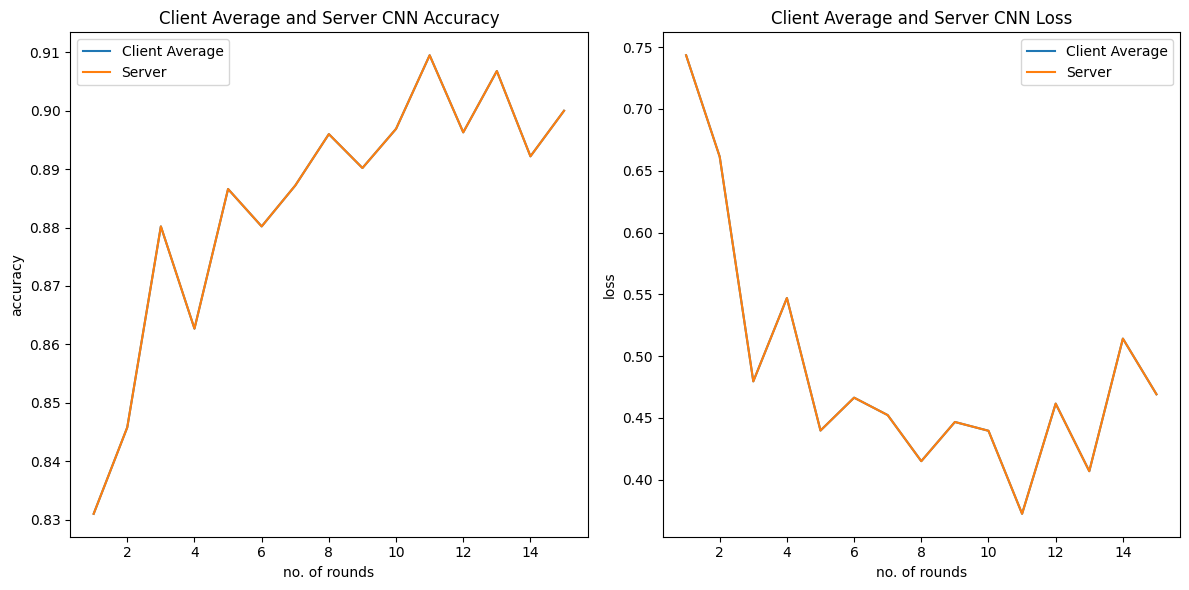

@@@@@@@@@@ avg client acc 0.8999999761581422
Client 1: 601 samples
Client 2: 503 samples
Client 3: 485 samples
Client 4: 307 samples
Client 5: 357 samples
Client 6: 50 samples
Client 7: 40 samples
Client 8: 308 samples
Client 9: 282 samples
Client 10: 154 samples
[[ 18   0 245   0 218  80   0   0  11  29]
 [ 25   0   0   0  20 450   3   5   0   0]
 [  2   0   0   0   0   0 481   2   0   0]
 [  1  42  27   0  92   0  20   0   0 125]
 [  0   0  85 153   0   0 105  14   0   0]
 [  3   1  32   4   1   0   0   0   0   9]
 [  0   0   0   1   0   0   0   0   0  39]
 [  0  29   0   9   0   0   0 106   2 162]
 [  0   0 115   0 167   0   0   0   0   0]
 [ 15   0  53   0  86   0   0   0   0   0]]


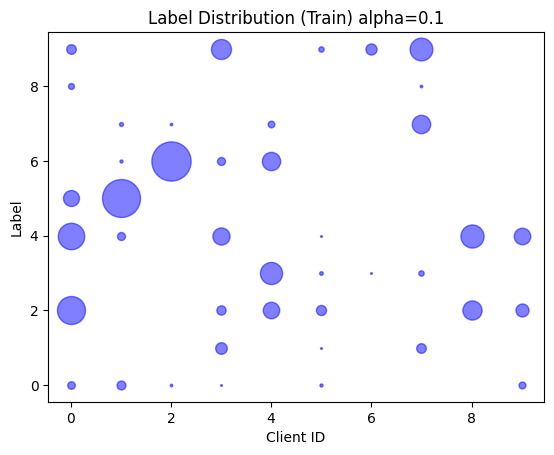

@@@@@@@@@@ centralised accuracy: 0.9448999762535095
@@@@@@@@@@ baseline accuracy: [0.5615000128746033, 0.4790000021457672, 0.6258000135421753, 0.7214000225067139, 0.6942999958992004, 0.7271000146865845, 0.6571999788284302, 0.8277999758720398, 0.7757999897003174, 0.6116999983787537]
0.6681600004434586
[[0.6574000120162964, 0.6176999807357788, 0.6173999905586243, 0.6068999767303467, 0.6225000023841858, 0.6162999868392944, 0.6093000173568726, 0.5810999870300293, 0.582099974155426, 0.5891000032424927, 0.6105999946594238, 0.59579998254776, 0.5995000004768372, 0.5895000100135803, 0.5990999937057495], [0.6574000120162964, 0.6176999807357788, 0.6173999905586243, 0.6068999767303467, 0.6225000023841858, 0.6162999868392944, 0.6093000173568726, 0.5810999870300293, 0.582099974155426, 0.5891000032424927, 0.6105999946594238, 0.59579998254776, 0.5995000004768372, 0.5895000100135803, 0.5990999937057495], [0.6574000120162964, 0.6176999807357788, 0.6173999905586243, 0.6068999767303467, 0.6225000023841858

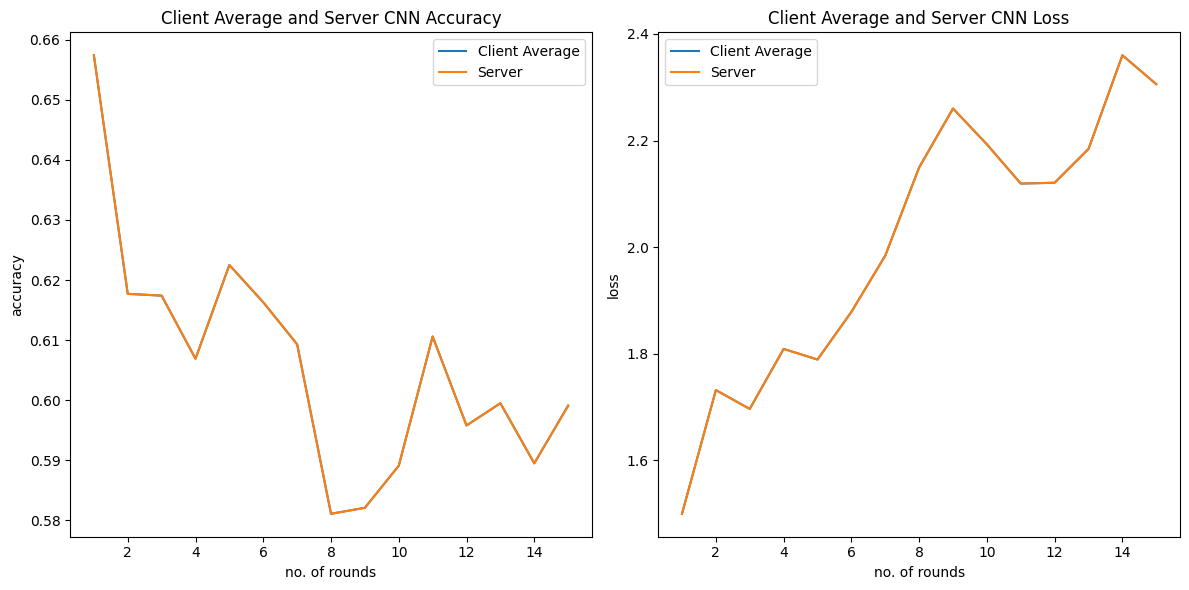

@@@@@@@@@@ avg client acc 0.5990999937057495
Client 1: 600 samples
Client 2: 540 samples
Client 3: 375 samples
Client 4: 177 samples
Client 5: 36 samples
Client 6: 296 samples
Client 7: 6 samples
Client 8: 383 samples
Client 9: 203 samples
Client 10: 339 samples
[[  8   0   0   0 136   0   0   5   0 451]
 [  0 536   0   0   2   0   2   0   0   0]
 [  0 138  72   0   0 158   0   0   7   0]
 [  0   0   0  16   0  13   0   0   0 148]
 [  0   0   0   0   0   2   1   2  31   0]
 [  0   0   0   0   0 146   5 145   0   0]
 [  0   0   0   0   0   0   0   0   6   0]
 [  0   0 378   0   0   0   4   0   1   0]
 [  0   0   1   0  78   8   2 114   0   0]
 [  6   0   0   0   0   0  50 283   0   0]]


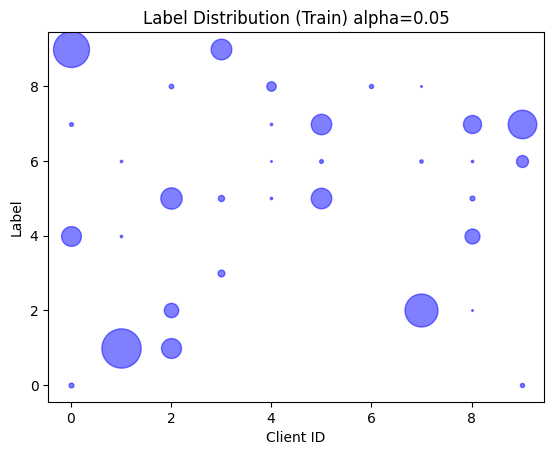

Epoch 17: early stopping
@@@@@@@@@@ centralised accuracy: 0.9556999802589417
@@@@@@@@@@ baseline accuracy: [0.8011000156402588, 0.7670999765396118, 0.7402999997138977, 0.6920999884605408, 0.9266999959945679, 0.7929999828338623, 0.802299976348877, 0.7560999989509583, 0.7232999801635742, 0.6385999917984009]
0.764059990644455
[[0.6642000079154968, 0.6292999982833862, 0.5849999785423279, 0.5740000009536743, 0.5608000159263611, 0.5568000078201294, 0.5411999821662903, 0.5205000042915344, 0.516700029373169, 0.5105000138282776, 0.5102999806404114, 0.4968000054359436, 0.4948999881744385, 0.5026000142097473, 0.4959999918937683], [0.6642000079154968, 0.6292999982833862, 0.5849999785423279, 0.5740000009536743, 0.5608000159263611, 0.5568000078201294, 0.5411999821662903, 0.5205000042915344, 0.516700029373169, 0.5105000138282776, 0.5102999806404114, 0.4968000054359436, 0.4948999881744385, 0.5026000142097473, 0.4959999918937683], [0.6642000079154968, 0.6292999982833862, 0.5849999785423279, 0.574000000

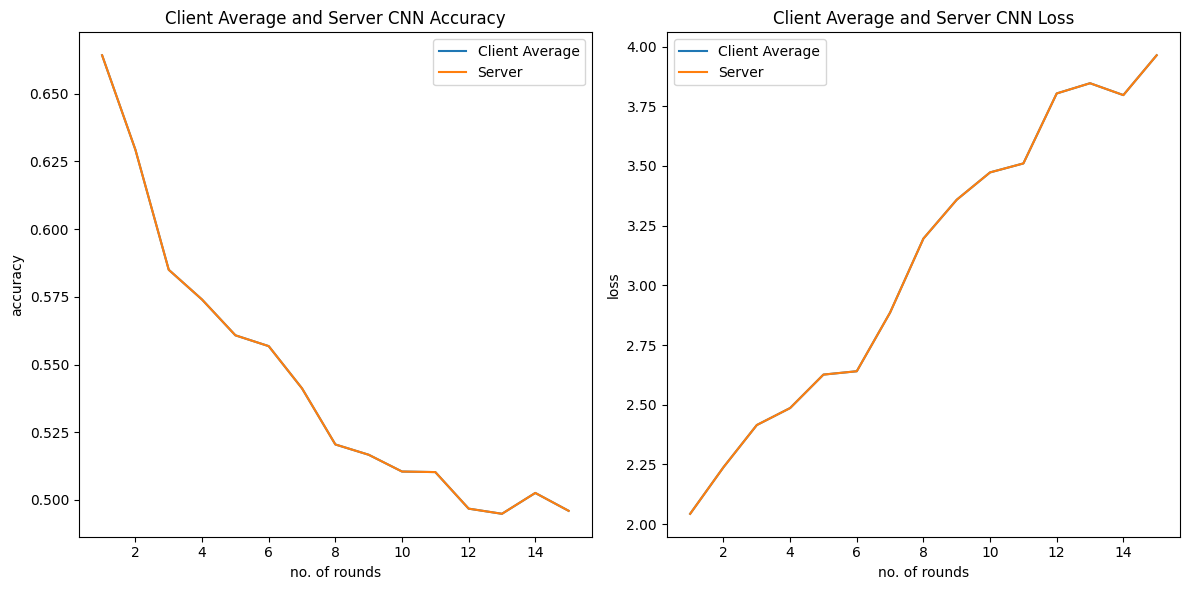

@@@@@@@@@@ avg client acc 0.4959999918937684


In [216]:
dir_alpha_ls=[0.5,0.1,0.05]
for dir_alpha in dir_alpha_ls:
  # generate client split
  client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha)
  for i, (x, y) in enumerate(client_data):
      print(f"Client {i+1}: {len(x)} samples")
  # Plot the bubble chart with normalized sizes
  plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)
  run_test(smallCNN(),client_data)


#Full Testing

## r=0.1,dir_alpha=0.5,alpha=0.3,smallCNN

In [28]:
x_sample, y_sample=sample_training_data(0.1)
print_dist(y_sample,'0.1')

Label Distribution in Training Set  0.1 :
Label 0: 589 instances
Label 1: 674 instances
Label 2: 589 instances
Label 3: 578 instances
Label 4: 584 instances
Label 5: 530 instances
Label 6: 609 instances
Label 7: 623 instances
Label 8: 625 instances
Label 9: 599 instances


Client 1: 600 samples
Client 2: 540 samples
Client 3: 485 samples
Client 4: 437 samples
Client 5: 337 samples
Client 6: 285 samples
Client 7: 327 samples
Client 8: 295 samples
Client 9: 224 samples
Client 10: 228 samples
[[  1  45  19  75 167  57 126   3  25  82]
 [ 16 139   1  66  27 124   2 123  10  32]
 [ 42   3   0   1  20 194 173   0  40  12]
 [ 20   5   0  17  23   6 225   2   5 134]
 [ 65   4 103   4  67   2  83   0   5   4]
 [  4   1  13   0  41  23   0  13  66 124]
 [ 14  99  71   3  10  60   0  26  30  14]
 [130   0  14  79  35  33   0   1   3   0]
 [  4  13  15  82   1   2   0  82  21   4]
 [  8  19   6  64   4   0   0  17  95  15]]


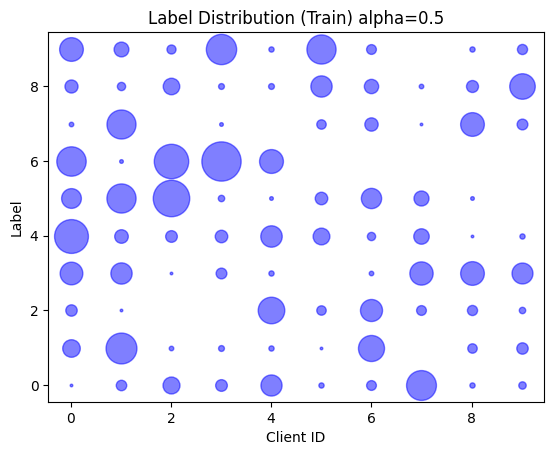

In [31]:
dir_alpha=0.5
client_data = dirichlet_split(x_sample, y_sample, alpha=dir_alpha)
for i, (x, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(x)} samples")
# Plot the bubble chart with normalized sizes
plot_bubble_chart(client_data_dist(client_data),dist_param=dir_alpha)

CENTRALISED START
Epoch 10: early stopping
@@@@@@@@@@ centralised accuracy: 0.9150000214576721
BASELINE START
@@@@@@@@@@ baseline accuracy: [0.8267999887466431, 0.7035999894142151, 0.6947000026702881, 0.7544000148773193, 0.7175999879837036, 0.8100000023841858, 0.7005000114440918, 0.6309000253677368, 0.685699999332428, 0.6819999814033508]
0.7206200003623963
FEDAVG START
FedAvg Round 0
[0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733, 0.7096999883651733]
global: 0.7096999883651733
FedAvg Round 1
[0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267, 0.7278000116348267]
global: 0.7278000116348267
FedAvg Round 2
[0.7340999841690063, 0.7340999841690063, 0.7340999841690063, 0.7340999841690063, 0.7340999841690063, 0.7340999841690063, 0.7340

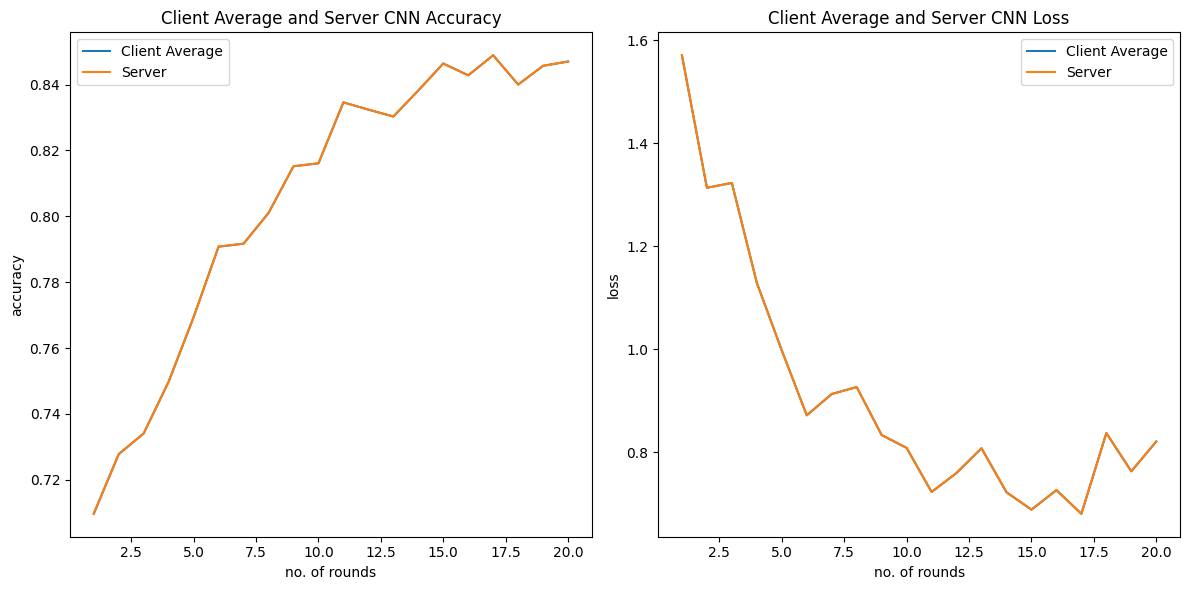

@@@@@@@@@@ avg client acc 0.8470000028610227
FEDPKDG START


NameError: name 'client_list' is not defined

In [32]:
run_test(smallCNN(),client_data)

In [35]:
client_list = []
for i in range(10):
  #partition dataset to mimic private data
  client_list.append(Client(smallCNN(), client_data[i][0], client_data[i][1]))
runpkdg(smallCNN(),client_list)

KeyboardInterrupt: 